## Amazon Alexa Review Classification

## Problem statement

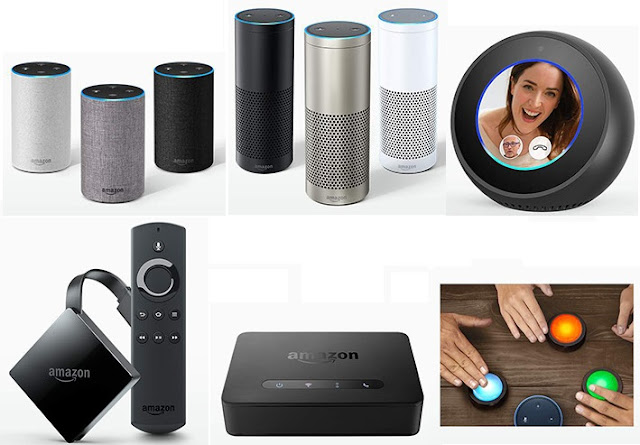

* Dataset consists of 3000 Amazon customer reviews, star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots.
* The objectives is to discover insights into consumer reviews and perform sentiment analysis on the data

## Step #0: Import libraries

In [1]:
#For loading dataset & for linear algebra
import pandas as pd
import numpy as np

#Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS

#ProfileReport
import pandas_profiling
from pandas_profiling import ProfileReport

#Model training preparation
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold


#For Natural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer

#Models: Classification
from sklearn.ensemble import (RandomForestClassifier,
                             BaggingClassifier,
                             AdaBoostClassifier, 
                             VotingClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import (roc_auc_score, 
                            confusion_matrix,
                            balanced_accuracy_score, 
                            classification_report, 
                            plot_confusion_matrix)


#Scikit-learn: imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import (BalancedBaggingClassifier, 
                              EasyEnsembleClassifier, 
                              RUSBoostClassifier, 
                              BalancedRandomForestClassifier)
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from collections import Counter

#Disable warnings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn import set_config
set_config(display="text")

### Some functions

In [2]:
# Show missing value in %

def percent_value_counts(df, variable):
    percent = pd.DataFrame(round(df[variable].value_counts(dropna = False, normalize = True)*100, 2))
    total = pd.DataFrame(df[variable].value_counts(dropna = False))
  
    total.columns = ["Total"]
    percent.columns = ['Percent %']
    return pd.concat([total, percent], axis = 1)

In [3]:
# Visualizing histogram, probability plot and box-plot

def diagnostic_plots(df, variable):
    fig = plt.figure()
    plt.figure(figsize = (18, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    fig = df[variable].hist(bins = 30)
    fig.set_ylabel ('Count')
    fig.set_xlabel(variable)
    
    # Probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist = 'norm', plot = plt)
    
    # Box-plot
    plt.subplot(1, 3, 3)
    fig = df.boxplot(column = variable)
    fig.set_title('Box-plot')
    fig.set_ylabel(variable)

    plt.show()

In [4]:
# Define GridSearchCV for model

def grid_search_model(model, param_grid, cv):
    grid_search = GridSearchCV(model, param_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc')
    return grid_search

## Step #1: Import data

In [5]:
# Load dataset

df_alexa = pd.read_csv('../amazon_alexa.tsv', sep = '\t')

In [6]:
# Show first ten rows

df_alexa.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [7]:
# Show last 10 rows

df_alexa.tail(10)

,rating,date,variation,verified_reviews,feedback
3140,4,30-Jul-18,White Dot,Barry,1
3141,3,30-Jul-18,Black Dot,,1
3142,4,30-Jul-18,White Dot,My three year old loves it. Good for doing ba...,1
3143,5,30-Jul-18,Black Dot,Awesome device wish I bought one ages ago.,1
3144,5,30-Jul-18,Black Dot,love it,1
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


'verified_reviews' has empty reviews. Most likely the user sent an empty review

## Step #2:  Explore / Visualising the data

In [8]:
# Using ProfileReport

profile = ProfileReport (df_alexa, title = 'Alexa_review', explorative = True, 
                         plot = {'correlation': {'annot': True}}, 
                         html = {'style': {'full_width': True }}) 

profile.to_file("amazon_alexa_report1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Look at positive and negative feedbacks

positive_feedback = df_alexa[df_alexa['feedback'] == 1]
negative_feedback = df_alexa[df_alexa['feedback'] == 0]

In [10]:
negative_feedback

,rating,date,variation,verified_reviews,feedback
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0
...,...,...,...,...,...
3047,1,30-Jul-18,Black Dot,Echo Dot responds to us when we aren't even ta...,0
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0
3067,2,30-Jul-18,Black Dot,The only negative we have on this product is t...,0
3091,1,30-Jul-18,Black Dot,I didn’t order it,0


In [11]:
positive_feedback

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [12]:
# See in % variation distribution in variable
percent_value_counts(df_alexa, 'variation')

,Total,Percent %
Black Dot,516,16.38
Charcoal Fabric,430,13.65
Configuration: Fire TV Stick,350,11.11
Black Plus,270,8.57
Black Show,265,8.41
Black,261,8.29
Black Spot,241,7.65
White Dot,184,5.84
Heather Gray Fabric,157,4.98
White Spot,109,3.46


In [12]:
# Positive and negative reviews for different Alexa variations

positive_products = positive_feedback['variation'].value_counts(ascending = True)
positive_products

Walnut Finish                     9
Oak Finish                       14
White  Plus                      70
White                            74
White  Show                      74
Sandstone Fabric                 84
White  Spot                      97
Heather Gray Fabric             155
White  Dot                      172
Black  Spot                     209
Black                           226
Black  Plus                     242
Black  Show                     247
Configuration: Fire TV Stick    322
Charcoal Fabric                 418
Black  Dot                      480
Name: variation, dtype: int64

In [13]:
negative_products = negative_feedback['variation'].value_counts(ascending = True)
negative_products

Heather Gray Fabric              2
Sandstone Fabric                 6
White  Plus                      8
White  Show                     11
Charcoal Fabric                 12
White  Spot                     12
White  Dot                      12
White                           17
Black  Show                     18
Black  Plus                     28
Configuration: Fire TV Stick    28
Black  Spot                     32
Black                           35
Black  Dot                      36
Name: variation, dtype: int64

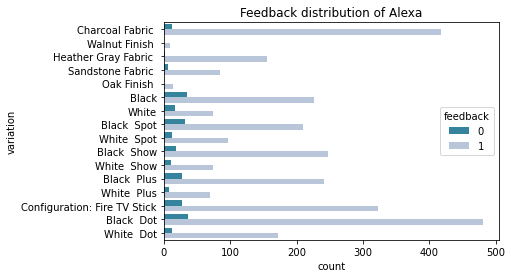

In [8]:
# Show distribution of different variations by feedback
fig = sns.countplot(y = 'variation', hue = 'feedback', data = df_alexa, palette = 'PuBuGn_r')
fig = fig.set_title('Feedback distribution of Alexa')
plt.show()

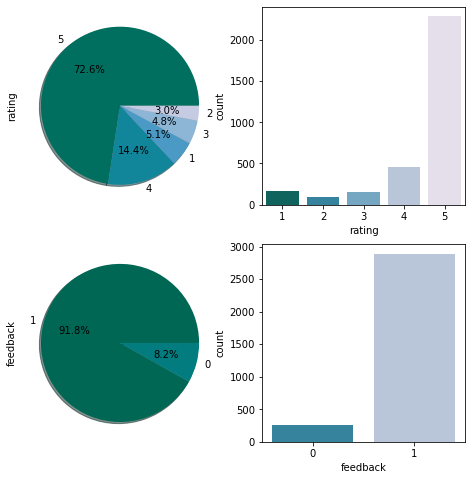

In [9]:
#Explore 'rating' and 'feedback'

cat_cols = ['rating','feedback']

plt.figure(figsize = (8, 8))
i = 1
for col in cat_cols:
    plt.subplot(2, 2, i)
    colors = sns.color_palette('PuBuGn_r', len(col))
    df_alexa[col].value_counts().plot.pie(shadow = True, autopct = '%1.1f%%', colors = colors)
    i += 1
    
    plt.subplot(2, 2, i)
    sns.countplot(x = col, data = df_alexa, palette = 'PuBuGn_r')
    i += 1
    
plt.show()

We have unbalanced dataset.

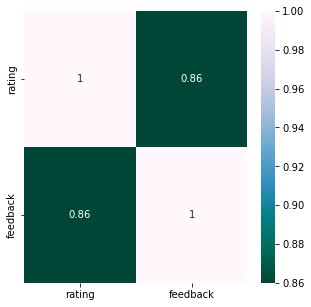

In [10]:
# Relationship between 'ratings' and 'feedback'

corr = df_alexa.corr().round(2)
fig = plt.figure(figsize = (5, 5))
sns.heatmap(corr, annot = True, cmap = 'PuBuGn_r')
plt.show()

Correlation between 'rating' & 'feedback' is 0.86, and 'feedback' is our target, so we drop 'rating' in Feature engineering part.

In [11]:
# Analysis of date

df_alexa['month'] = pd.DatetimeIndex(df_alexa['date']).month
df_alexa['weekday'] = pd.DatetimeIndex(df_alexa['date']).weekday
df_alexa.head(15)

,rating,date,variation,verified_reviews,feedback,month,weekday
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,7,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,7,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,1
4,5,31-Jul-18,Charcoal Fabric,Music,1,7,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,7,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,7,1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,7,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1,7,0
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,7,0


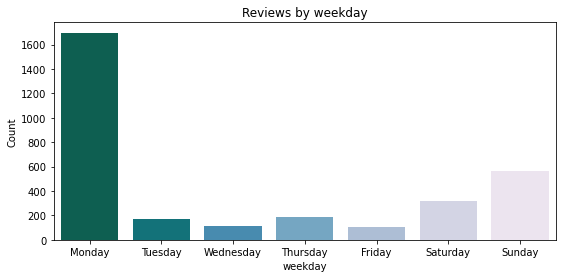

In [12]:
plt.figure(figsize = (9, 4))
sns.countplot(x = df_alexa['weekday'], data = df_alexa, palette = 'PuBuGn_r')
plt.xticks(range(7), 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split())
plt.ylabel('Count')
plt.title('Reviews by weekday')
plt.show()

Maximum reviews posted on Monday, then on weekends

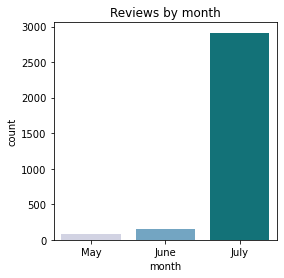

In [13]:
plt.figure(figsize = (4, 4))
sns.countplot(x = 'month', data = df_alexa, palette = 'PuBuGn')
plt.xticks(range(3), 'May June July'.split())
plt.title('Reviews by month')
plt.show()

Maximum reviews were submitted on July. 

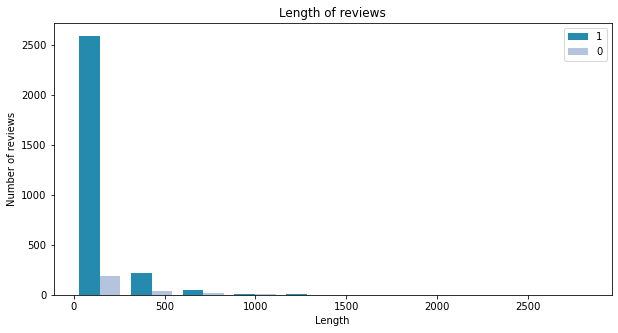

In [16]:
# Length of reviews

pos_lengths = positive_feedback['verified_reviews'].str.len()
neg_lenghts = negative_feedback['verified_reviews'].str.len()

plt.figure(figsize = (10, 5))
colors = sns.color_palette('PuBuGn_r', 2) 
plt.hist([pos_lengths, neg_lenghts], label = ['1', '0'], color = colors)
plt.title('Length of reviews')
plt.ylabel('Number of reviews')
plt.xlabel('Length')
plt.legend(loc = 'best')
plt.show()

In [17]:
df_alexa['length'] = df_alexa['verified_reviews'].apply(len)
df_alexa.head()

,rating,date,variation,verified_reviews,feedback,month,weekday,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,7,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,7,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,7,1,5


<Figure size 432x288 with 0 Axes>

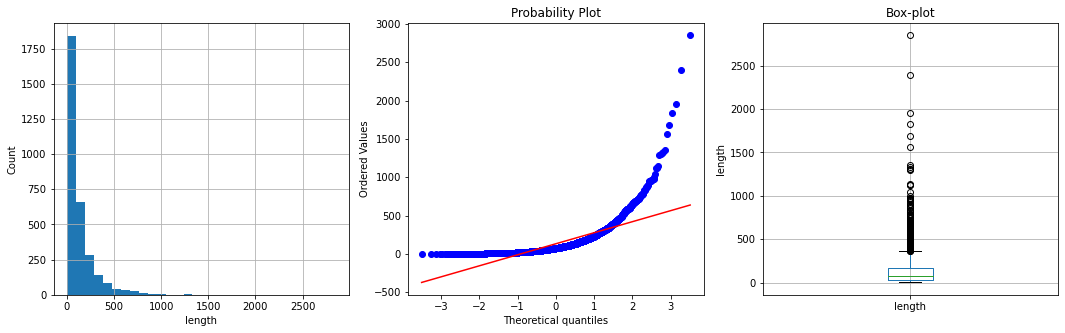

In [18]:
diagnostic_plots(df_alexa, 'length')

Distribution of 'length' is skewed

In [23]:
df_alexa.length.describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [24]:
df_alexa[df_alexa['length'] == 2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

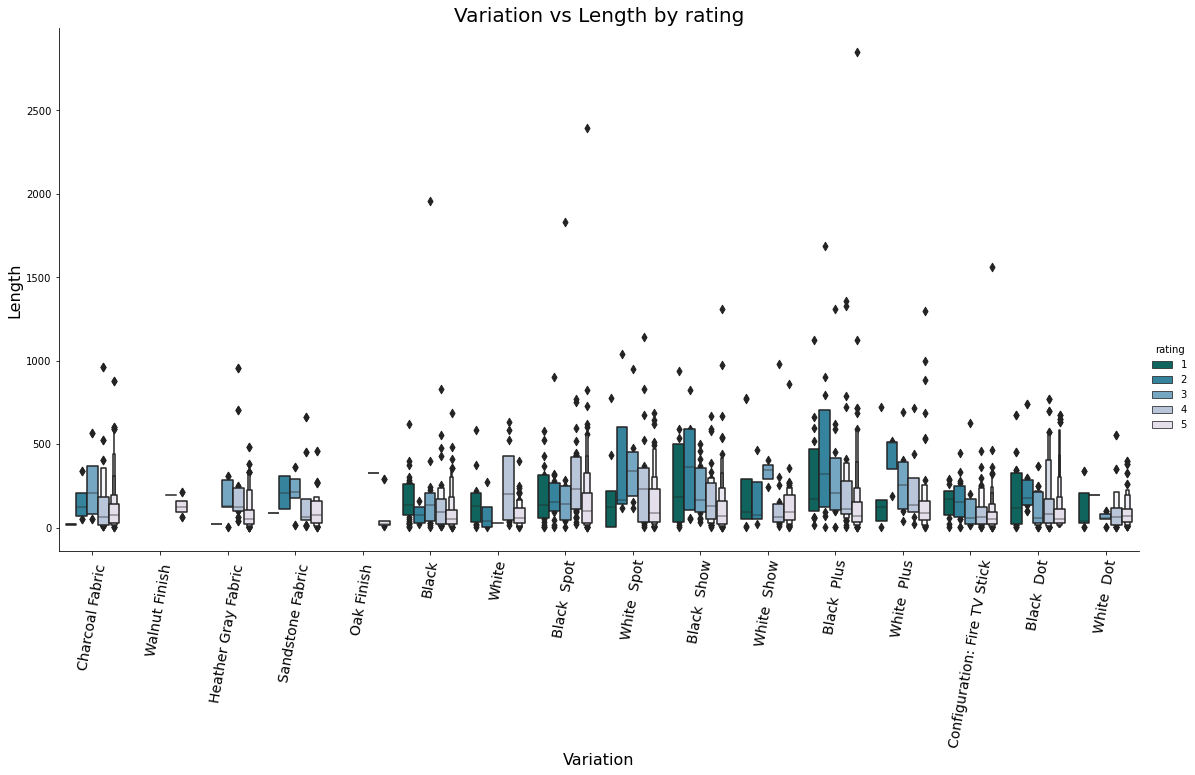

In [19]:
sns.catplot(data = df_alexa, x = 'variation', y = 'length', hue = 'rating', kind = 'boxen', palette = 'PuBuGn_r', 
           height = 8, aspect = 2)
plt.xticks(fontsize = 14, rotation = 80)
plt.xlabel('Variation', fontsize = 16)
plt.ylabel('Length', fontsize = 16)
plt.title('Variation vs Length by rating', fontsize = 20)
plt.show()

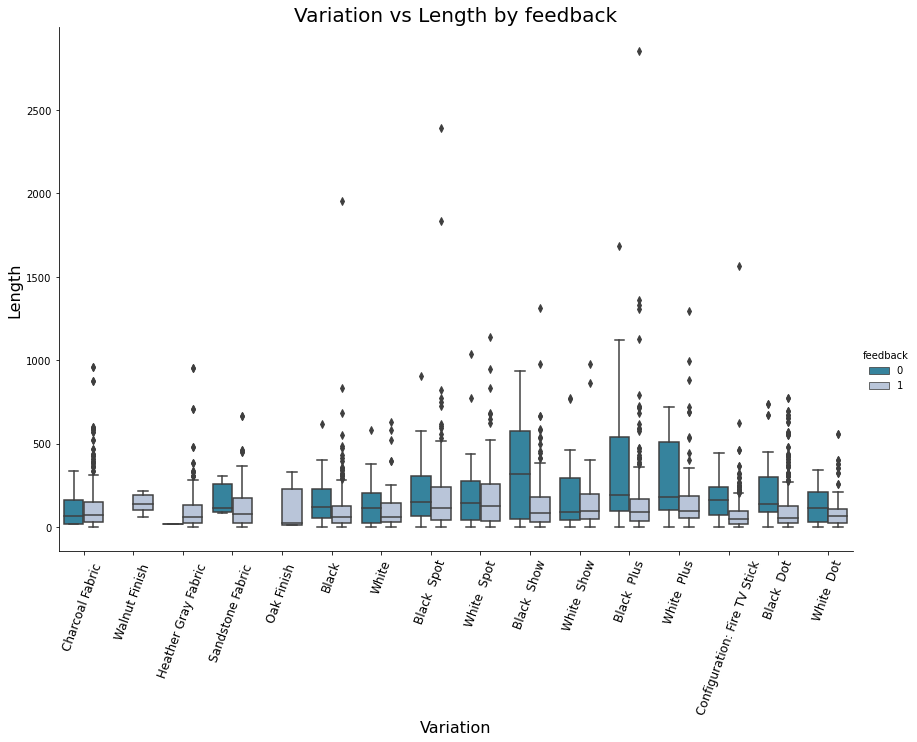

In [20]:
sns.catplot(data = df_alexa, x = 'variation', y = 'length', hue = 'feedback', kind = 'box', palette = 'PuBuGn_r', 
           height = 8, aspect = 1.5)
plt.xticks(fontsize = 12, rotation = 70)
plt.xlabel('Variation', fontsize = 16)
plt.ylabel('Length', fontsize = 16)
plt.title('Variation vs Length by feedback', fontsize = 20)
plt.show()

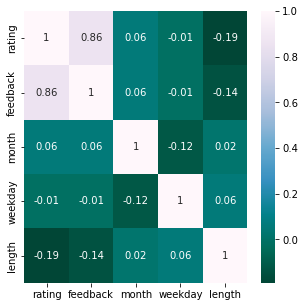

In [21]:
# Correlation

corr = df_alexa.corr().round(2)
fig = plt.figure(figsize = (5, 5))
sns.heatmap(corr, annot = True, cmap = 'PuBuGn_r')
plt.show()

### Word cloud feedback

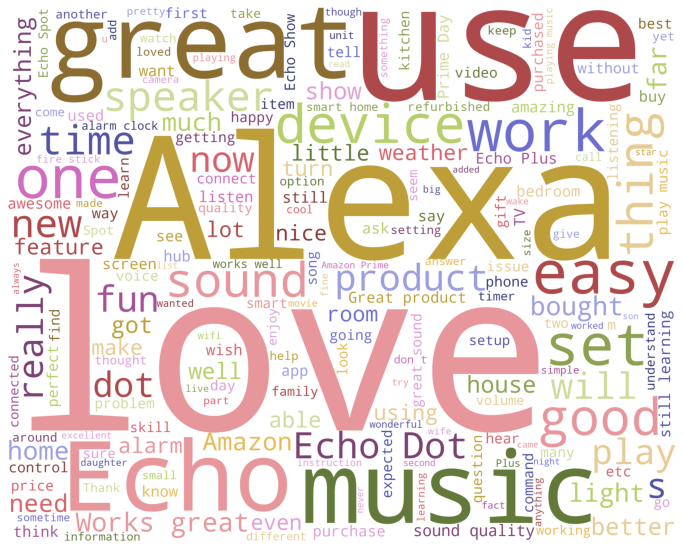

In [22]:
df_pos = df_alexa[df_alexa['feedback'] == 1]['verified_reviews']
wordcloud_pos = WordCloud(stopwords = STOPWORDS, background_color = 'white', width = 2500,
                      height = 2000, colormap = 'tab20b_r').generate(" ".join(df_pos))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

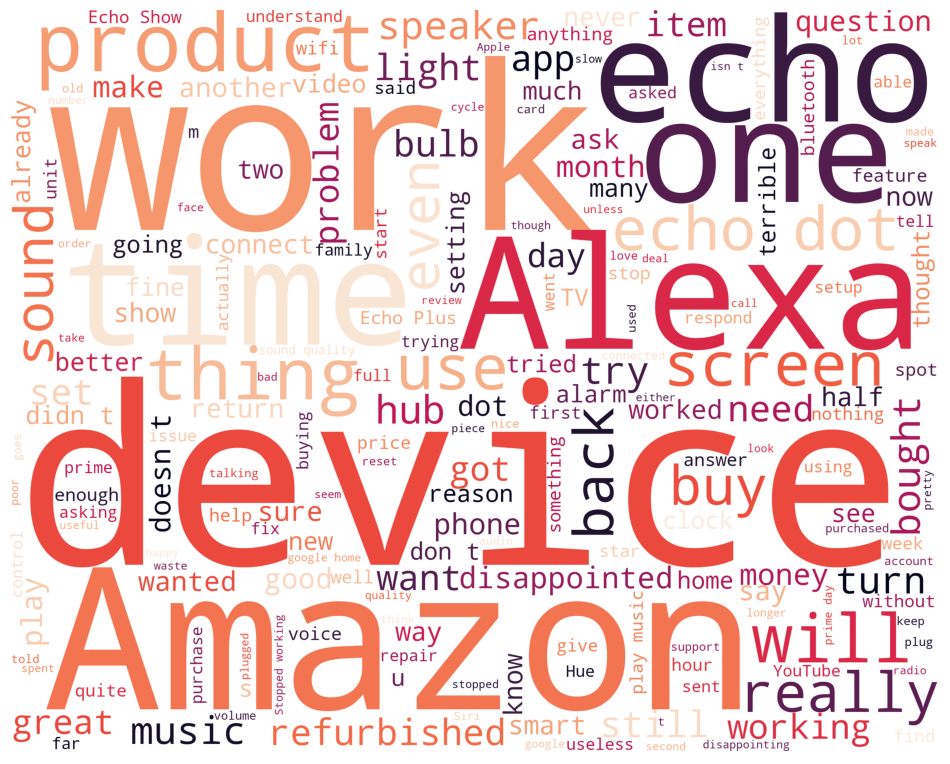

In [29]:
df_neg = df_alexa[df_alexa['feedback'] == 0]['verified_reviews']
wordcloud_neg = WordCloud(stopwords = STOPWORDS, background_color = 'white', width = 2500,
                      height = 2000, colormap = 'rocket_r').generate(" ".join(df_neg))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

## Step #3: Prepare the data for training / data cleaning

### Text preprocessing

In [30]:
df_alexa.head()

,rating,date,variation,verified_reviews,feedback,month,weekday,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,7,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,7,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,7,1,5


In [23]:
# Text feature extraction
vectorizer = TfidfVectorizer(stop_words = 'english')
alexa_vectorizer = vectorizer.fit_transform(df_alexa['verified_reviews'])

In [19]:
alexa_vectorizer.shape

(3150, 3784)

In [28]:
print(vectorizer.get_feature_names())

['00', '000', '07', '10', '100', '100x', '11', '1100sf', '12', '129', '12am', '15', '150', '18', '19', '1964', '1990', '1gb', '1rst', '1st', '20', '200', '2000', '2017', '229', '23', '24', '25', '29', '2nd', '2package', '30', '300', '30pm', '34', '360', '39', '3rd', '3x', '3xs', '40', '45', '48', '4am', '4ghz', '4k', '4th', '50', '54', '5am', '5ghz', '5th', '600', '62', '672', '6th', '70', '75', '79', '80', '80s', '81', '83', '85', '88', '888', '8gb', '90', '91', '911', '99', '_specifically_', 'a1', 'a19', 'abay', 'abc', 'abd', 'abilities', 'ability', 'able', 'abode', 'absolutely', 'absolutly', 'ac', 'accent', 'acceptable', 'accepting', 'access', 'accessable', 'accessible', 'accessing', 'accessories', 'accesss', 'accident', 'accidentally', 'accompanying', 'accomplish', 'accomplished', 'according', 'accordingly', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'accustom', 'acknowledge', 'acoustical', 'act', 'acting', 'action', 'actions', 'activate', 'activated', 'activates'

In [24]:
# Convert to DataFrame
reviews = pd.DataFrame(alexa_vectorizer.toarray())

In [25]:
df_alexa = pd.concat([df_alexa, reviews], axis = 1)

In [26]:
df_alexa.drop(['verified_reviews'], axis = 1, inplace = True)

In [27]:
df_alexa.head()

rating       date         variation  feedback  month  weekday  length    0  \
0       5  31-Jul-18  Charcoal Fabric          1      7        1      13  0.0   
1       5  31-Jul-18  Charcoal Fabric          1      7        1       9  0.0   
2       4  31-Jul-18    Walnut Finish          1      7        1     195  0.0   
3       5  31-Jul-18  Charcoal Fabric          1      7        1     172  0.0   
4       5  31-Jul-18  Charcoal Fabric          1      7        1       5  0.0   

     1    2    3    4    5    6    7    8    9   10   11   12   13   14   15  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    16   17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    31   32   33   34   35   36   37   38   39   40   41   42   43   44   45  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    46   47   48   49   50   51   52   53   54   55   56   57   58   59   60  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    61   62   63   64   65   66   67   68   69   70   71   72   73   74   75  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    76   77   78        79   80   81   82   83   84   85   86   87   88   89  \
0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.206486  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    90   91   92   93   94   95   96   97   98   99  100  101  102  103  104  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [24]:
df_alexa.shape

(3150, 3791)

In [28]:
# Drop features that do not add value to our model
df_alexa.drop(['date', 
               'rating', 
               'month', 
               'weekday', 
               'length', 
               'variation'], axis = 1, inplace = True)

In [29]:
X = df_alexa.drop(['feedback'], axis = 1)
y = df_alexa['feedback']

In [30]:
# Split dataset on train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [31]:
X_train.shape, X_test.shape

((2520, 3784), (630, 3784))

In [32]:
X_train.head()

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       70   71   72   73   74   75   76   77   78   79   80   81   82   83  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       84   85   86   87   88   89   90   91   92   93   94   95   96   97  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       98   99  100  101  102  103  104  105  106  107  108  109  110  111  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
493   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      112  113  114  115  116  117  118  119  120  121  122  123  124  125  \
2859  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
793   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2875  0.0  0.0  0.0  0

In [33]:
# Define cv with RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

### Prepare additional datasets with using specific libraries from imbalanced_learn

In [34]:
#Oversampling dataset
random_os = RandomOverSampler(random_state = 10)
X_train_os, y_train_os = random_os.fit_resample(X_train, y_train)

In [35]:
print(Counter(y_train_os))

Counter({1: 2317, 0: 2317})


In [36]:
# Undesampling dataset
random_us = RandomUnderSampler(random_state = 10)
X_train_us, y_train_us = random_us.fit_resample(X_train, y_train)

In [37]:
print(Counter(y_train_us))

Counter({0: 203, 1: 203})


In [38]:
# To save the model results into lists
model_list = []
roc_auc_score_list = []
balanced_accuracy_list = []
geometric_mean_list = []

Strategies how to fitting model on imbalanced dataset:

1. Penalize with parameter class_weight = 'balanced'
2. Balancing the class before classification: from sklearn.imblearn - RandomUnderSampler, RandomOverSample
3. Use of specific balanced algorithms from imbalanced-learn: 
- BalancedRandomForestClassifier
- EasyEnsembleClassifier, 
- RUSBoostClassifier
- BalancedBaggingClassifier

## Step #4: Model training & Searching hyperparameters with Grid-Search CV

## Logistic Regression

In [39]:
log_reg = LogisticRegression(random_state = 0, class_weight = 'balanced', C = 0.01)

In [40]:
log_reg_param_grid = { 
    'max_iter': [200, 300, 400],
    'penalty': ['l1', 'l2'], 
    'solver': ['lbfgs', 'liblinear'], 
    'multi_class': ['auto', 'ovr', 'multinomial']
}

In [41]:
log_reg_grid_search = grid_search_model(log_reg, log_reg_param_grid, cv)

In [42]:
log_reg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=1),
             estimator=LogisticRegression(C=0.01, class_weight='balanced',
                                          random_state=0),
             n_jobs=-1,
             param_grid={'max_iter': [200, 300, 400],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [43]:
log_reg_grid_search.best_params_

{'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [44]:
y_pred_log_train = log_reg_grid_search.predict(X_train)

cm_log_train = confusion_matrix(y_train, y_pred_log_train)
cm_log_train

array([[ 198,    5],
       [ 507, 1810]])

In [45]:
y_pred_log_test = log_reg_grid_search.predict(X_test)

cm_log_test = confusion_matrix(y_test, y_pred_log_test)
cm_log_test

array([[ 51,   3],
       [134, 442]])

In [46]:
print('Train set')
print('Logistic Regression roc-auc: {}'. format(roc_auc_score(y_train, y_pred_log_train)))

print('Test set')
print('Logistic Regresssion roc-auc: {}'. format(roc_auc_score(y_test, y_pred_log_test)))

Train set
Logistic Regression roc-auc: 0.8782760108939919
Test set
Logistic Regresssion roc-auc: 0.8559027777777778


In [47]:
print(classification_report_imbalanced(y_train, y_pred_log_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.98      0.78      0.44      0.87      0.78       203
          1       1.00      0.78      0.98      0.88      0.87      0.75      2317

avg / total       0.94      0.80      0.96      0.84      0.87      0.75      2520



In [48]:
print(classification_report_imbalanced(y_test, y_pred_log_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.94      0.77      0.43      0.85      0.74        54
          1       0.99      0.77      0.94      0.87      0.85      0.71       576

avg / total       0.93      0.78      0.93      0.83      0.85      0.71       630



In [49]:
# Save the model results into lists
model_list.append('Logistic Regression')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_log_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_log_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_log_test), 3))

## Logistic Regression with oversampling

In [50]:
lr_clf_os = LogisticRegression(random_state = 0, max_iter = 200, penalty = 'l2', 
                               solver = 'liblinear', C = 0.01, multi_class = 'multinomial')

In [51]:
lr_clf_os_grid_search = grid_search_model(lr_clf_os, log_reg_param_grid, cv)

In [52]:
%%timeit -r 1 -n 1
lr_clf_os_grid_search.fit(X_train_os, y_train_os)

8min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [53]:
lr_clf_os_grid_search.best_params_

{'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [54]:
y_pred_lr_clf_os_train = lr_clf_os_grid_search.predict(X_train_os)

cm_lr_clf_train = confusion_matrix(y_train_os, y_pred_lr_clf_os_train)
cm_lr_clf_train

array([[2285,   32],
       [ 446, 1871]])

In [55]:
y_pred_lr_clf_os_test = lr_clf_os_grid_search.predict(X_test)

cm_lr_clf_os_test = confusion_matrix(y_test, y_pred_lr_clf_os_test)
cm_lr_clf_os_test

array([[ 51,   3],
       [123, 453]])

In [56]:
print('Train set')
print('Logistic Regression with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_lr_clf_os_train)))

print('Test set')
print('Logistic Regresssion with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_lr_clf_os_test)))

Train set
Logistic Regression with oversampling roc-auc: 0.8968493741907639
Test set
Logistic Regresssion with oversampling roc-auc: 0.8654513888888888


In [57]:
print(classification_report_imbalanced(y_train_os, y_pred_lr_clf_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.99      0.81      0.91      0.89      0.81      2317
          1       0.98      0.81      0.99      0.89      0.89      0.78      2317

avg / total       0.91      0.90      0.90      0.90      0.89      0.80      4634



In [58]:
print(classification_report_imbalanced(y_test, y_pred_lr_clf_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.29      0.94      0.79      0.45      0.86      0.75        54
          1       0.99      0.79      0.94      0.88      0.86      0.73       576

avg / total       0.93      0.80      0.93      0.84      0.86      0.73       630



In [59]:
# Save the model results into lists
model_list.append('Logistic Regression (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_lr_clf_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_lr_clf_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_lr_clf_os_test), 3))

## Logistic Regression with undersampling

In [60]:
lr_clf_us = LogisticRegression(random_state = 0, max_iter = 200, penalty = 'l2', solver = 'liblinear', C = 0.01, 
                                              multi_class = 'multinomial')

In [61]:
lr_clf_us_grid_search = grid_search_model(lr_clf_us, log_reg_param_grid, cv)

In [62]:
%%timeit -r 1 -n 1

lr_clf_us_grid_search.fit(X_train_us, y_train_us)

2min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [63]:
lr_clf_us_grid_search.best_params_

{'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [64]:
y_pred_lr_clf_us_train = lr_clf_us_grid_search.predict(X_train_us)

cm_lr_clf_us_train = confusion_matrix(y_train_us, y_pred_lr_clf_us_train)
cm_lr_clf_us_train

array([[201,   2],
       [ 37, 166]])

In [65]:
y_pred_lr_clf_us_test = lr_clf_us_grid_search.predict(X_test)

cm_lr_clf_us_test = confusion_matrix(y_test, y_pred_lr_clf_us_test)
cm_lr_clf_us_test

array([[ 53,   1],
       [202, 374]])

In [66]:
print('Train set')
print('Logistic Regression undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_lr_clf_us_train)))

print('Test set')
print('Logistic Regresssion undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_lr_clf_us_test)))

Train set
Logistic Regression undersampling roc-auc: 0.9039408866995075
Test set
Logistic Regresssion undersampling roc-auc: 0.8153935185185185


In [67]:
print(classification_report_imbalanced(y_train_us, y_pred_lr_clf_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.99      0.82      0.91      0.90      0.82       203
          1       0.99      0.82      0.99      0.89      0.90      0.80       203

avg / total       0.92      0.90      0.90      0.90      0.90      0.81       406



In [68]:
print(classification_report_imbalanced(y_test, y_pred_lr_clf_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.21      0.98      0.65      0.34      0.80      0.66        54
          1       1.00      0.65      0.98      0.79      0.80      0.62       576

avg / total       0.93      0.68      0.95      0.75      0.80      0.62       630



In [69]:
# Save the model results into lists
model_list.append('Logistic Regression (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_lr_clf_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_lr_clf_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_lr_clf_us_test), 3))

## Confusion matrix: Logistic Regression

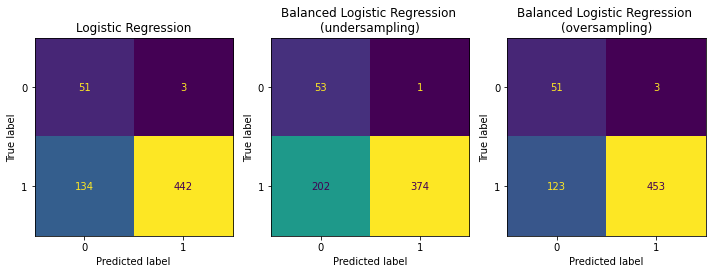

In [70]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(log_reg_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Logistic Regression")

plot_confusion_matrix(lr_clf_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Logistic Regression \n(undersampling)")

plot_confusion_matrix(lr_clf_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Logistic Regression \n(oversampling)")

fig.tight_layout()

## BaggingClassifier

In [143]:
bag_clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 7,
                            class_weight = 'balanced'), n_estimators = 100)

In [144]:
bag_clf_param_grid = {
     #'n_estimators': [30, 50, 100], 
}

In [145]:
bag_clf_grid_search = grid_search_model(bag_clf, bag_clf_param_grid, cv)

In [146]:
%%timeit -r 1 -n 1
bag_clf_grid_search.fit(X_train, y_train)

1min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [147]:
bag_clf_grid_search.best_params_

{}

In [148]:
y_pred_bag_train = bag_clf_grid_search.predict(X_train)

cm_bag_train = confusion_matrix(y_train, y_pred_bag_train)
cm_bag_train

array([[ 201,    2],
       [ 836, 1481]])

In [149]:
y_pred_bag_test = bag_clf_grid_search.predict(X_test)

cm_bag_test = confusion_matrix(y_test, y_pred_bag_test)
cm_bag_test

array([[ 50,   4],
       [217, 359]])

In [150]:
print('Train set')
print('Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_pred_bag_train)))

print('Test set')
print('Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_bag_test)))

Train set
Bagging Classifier roc-auc: 0.8146681946036047
Test set
Bagging Classifier roc-auc: 0.7745949074074074


In [820]:
print(classification_report_imbalanced(y_train, y_pred_bag_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.19      0.99      0.64      0.32      0.80      0.66       203
          1       1.00      0.64      0.99      0.78      0.80      0.61      2317

avg / total       0.93      0.67      0.96      0.74      0.80      0.61      2520



In [151]:
print(classification_report_imbalanced(y_test, y_pred_bag_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.19      0.93      0.62      0.31      0.76      0.59        54
          1       0.99      0.62      0.93      0.76      0.76      0.56       576

avg / total       0.92      0.65      0.90      0.73      0.76      0.56       630



In [850]:
# Save the model results into lists
model_list.append('Bagging Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_bag_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_bag_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_bag_test), 3))

## BaggingClassifier with oversampling

In [153]:
bag_os = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 7), 
                           n_estimators = 100)

In [154]:
bag_os_grid_search = grid_search_model(bag_os, bag_clf_param_grid, cv)

In [155]:
%%timeit -r 1 -n 1
bag_os_grid_search.fit(X_train_os, y_train_os)

3min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [156]:
bag_os_grid_search.best_params_

{}

In [157]:
y_pred_bag_os_train = bag_os_grid_search.predict(X_train_os)

cm_bag_os_train = confusion_matrix(y_train_os, y_pred_bag_os_train)
cm_bag_os_train

array([[2317,    0],
       [ 959, 1358]])

In [158]:
y_pred_bag_os_test = bag_os_grid_search.predict(X_test)

cm_bag_os_test = confusion_matrix(y_test, y_pred_bag_os_test)
cm_bag_os_test

array([[ 51,   3],
       [238, 338]])

In [159]:
print('Train set')
print('BaggingClassifier with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_bag_os_train)))

print('Test set')
print('BaggingClassifier with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_bag_os_test)))

Train set
BaggingClassifier with oversampling roc-auc: 0.7930513595166163
Test set
BaggingClassifier with oversampling roc-auc: 0.765625


In [819]:
print(classification_report_imbalanced(y_train_os, y_pred_bag_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      1.00      0.59      0.83      0.77      0.61      2317
          1       1.00      0.59      1.00      0.74      0.77      0.56      2317

avg / total       0.85      0.79      0.79      0.78      0.77      0.59      4634



In [160]:
print(classification_report_imbalanced(y_test, y_pred_bag_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.18      0.94      0.59      0.30      0.74      0.57        54
          1       0.99      0.59      0.94      0.74      0.74      0.53       576

avg / total       0.92      0.62      0.91      0.70      0.74      0.54       630



In [851]:
# Save the model results into lists
model_list.append('Bagging Classifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_bag_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_bag_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_bag_os_test), 3))

## BaggingClassifier with undersampling

In [162]:
bag_us = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 7), n_estimators = 100)

In [163]:
bag_us_grid_search = grid_search_model(bag_us, bag_clf_param_grid, cv)

In [164]:
%%timeit -r 1 -n 1
bag_us_grid_search.fit(X_train_us, y_train_us)

14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [165]:
bag_us_grid_search.best_params_

{}

In [166]:
y_pred_bag_us_train = bag_us_grid_search.predict(X_train_us)

cm_bag_us_train = confusion_matrix(y_train_us, y_pred_bag_us_train)
cm_bag_us_train

array([[202,   1],
       [ 73, 130]])

In [167]:
y_pred_bag_us_test = bag_us_grid_search.predict(X_test)

cm_bag_us_test = confusion_matrix(y_test, y_pred_bag_us_test)
cm_bag_us_test

array([[ 50,   4],
       [231, 345]])

In [168]:
print('Train set')
print('BaggingClassifier with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_bag_us_train)))

print('Test set')
print('BaggingClassifier with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_bag_us_test)))

Train set
BaggingClassifier with undersampling roc-auc: 0.8177339901477833
Test set
BaggingClassifier with undersampling roc-auc: 0.7624421296296297


In [818]:
print(classification_report_imbalanced(y_train_us, y_pred_bag_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      1.00      0.64      0.85      0.80      0.66       203
          1       0.99      0.64      1.00      0.78      0.80      0.61       203

avg / total       0.86      0.82      0.82      0.81      0.80      0.64       406



In [169]:
print(classification_report_imbalanced(y_test, y_pred_bag_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.18      0.93      0.60      0.30      0.74      0.57        54
          1       0.99      0.60      0.93      0.75      0.74      0.54       576

avg / total       0.92      0.63      0.90      0.71      0.74      0.54       630



In [852]:
# Save the model results into lists
model_list.append('Bagging Classifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_bag_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_bag_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_bag_us_test), 3))

## Confusion matrix:  Bagging Classifier

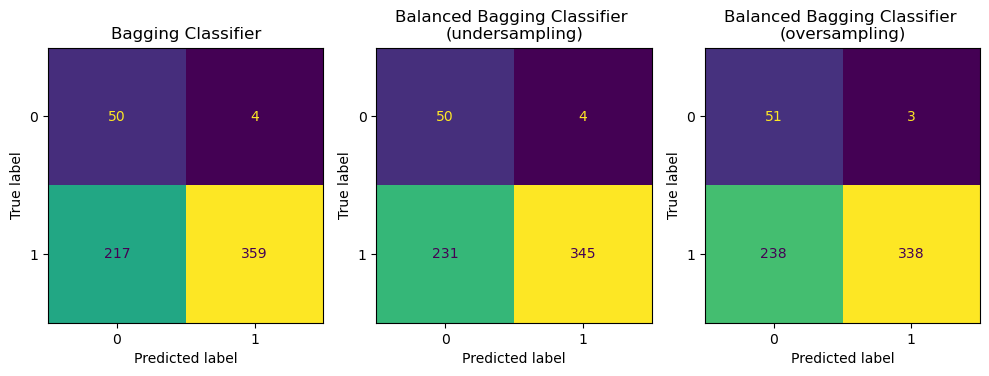

In [171]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(bag_clf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Bagging Classifier")

plot_confusion_matrix(bag_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Bagging Classifier \n(undersampling)")

plot_confusion_matrix(bag_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Bagging Classifier \n(oversampling)")

fig.tight_layout()

## Bernoulli Naive Bayes

In [172]:
nb = BernoulliNB()

In [173]:
nb_param_grid = { 'alpha': [0.01, 0.1, 1, 10]}

In [174]:
nb_grid_search = grid_search_model(nb, nb_param_grid, cv)

In [175]:
%%timeit -r 1 -n 1
nb_grid_search.fit(X_train, y_train)

8.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [176]:
nb_grid_search.best_params_

{'alpha': 0.1}

In [177]:
y_pred_nb_train = nb_grid_search.predict(X_train)

cm_nb_train = confusion_matrix(y_train, y_pred_nb_train)
cm_nb_train

array([[ 140,   63],
       [  25, 2292]])

In [178]:
y_pred_nb_test = nb_grid_search.predict(X_test)

cm_nb_test = confusion_matrix(y_test, y_pred_nb_test)
cm_nb_test

array([[ 31,  23],
       [ 24, 552]])

In [179]:
print('Train set')
print('Bernoulli Naive Bayes roc-auc: {}'. format(roc_auc_score(y_train, y_pred_nb_train)))

print('Test set')
print('Bernoulli Naive Bayes roc-auc: {}'. format(roc_auc_score(y_test, y_pred_nb_test)))

Train set
Bernoulli Naive Bayes roc-auc: 0.8394326789993005
Test set
Bernoulli Naive Bayes roc-auc: 0.7662037037037037


In [817]:
print(classification_report_imbalanced(y_train, y_pred_nb_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.69      0.99      0.76      0.83      0.66       203
          1       0.97      0.99      0.69      0.98      0.83      0.70      2317

avg / total       0.96      0.97      0.71      0.96      0.83      0.70      2520



In [180]:
print(classification_report_imbalanced(y_test, y_pred_nb_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.56      0.57      0.96      0.57      0.74      0.53        54
          1       0.96      0.96      0.57      0.96      0.74      0.57       576

avg / total       0.93      0.93      0.61      0.93      0.74      0.57       630



In [853]:
# Save the model results into lists
model_list.append('Bernoulli Naive Bayes')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_nb_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_nb_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_nb_test), 3))

## Naive Bayes with undersampling

In [182]:
nb_us = BernoulliNB()

In [183]:
nb_us_grid_search = grid_search_model(nb_us, nb_param_grid, cv)

In [184]:
%%timeit -r 1 -n 1
nb_us_grid_search.fit(X_train_us, y_train_us)

2.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [185]:
nb_us_grid_search.best_params_

{'alpha': 1}

In [186]:
y_pred_nb_us_train = nb_us_grid_search.predict(X_train_us)

cm_nb_us_train = confusion_matrix(y_train_us, y_pred_nb_us_train)
cm_nb_us_train

array([[127,  76],
       [  0, 203]])

In [187]:
y_pred_nb_us_test = nb_us_grid_search.predict(X_test)

cm_nb_us_test = confusion_matrix(y_test, y_pred_nb_us_test)
cm_nb_us_test

array([[ 31,  23],
       [ 30, 546]])

In [188]:
print('Train set')
print('Bernoulli Naive Bayes undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_nb_us_train)))

print('Test set')
print('Bernoulli Naive Bayes undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_nb_us_test)))

Train set
Bernoulli Naive Bayes undersampling roc-auc: 0.812807881773399
Test set
Bernoulli Naive Bayes undersampling roc-auc: 0.7609953703703703


In [816]:
print(classification_report_imbalanced(y_train_us, y_pred_nb_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.63      1.00      0.77      0.79      0.60       203
          1       0.73      1.00      0.63      0.84      0.79      0.65       203

avg / total       0.86      0.81      0.81      0.81      0.79      0.63       406



In [189]:
print(classification_report_imbalanced(y_test, y_pred_nb_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.51      0.57      0.95      0.54      0.74      0.52        54
          1       0.96      0.95      0.57      0.95      0.74      0.56       576

avg / total       0.92      0.92      0.61      0.92      0.74      0.56       630



In [854]:
# Save the model results into lists
model_list.append('Bernoulli Naive Bayes (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_nb_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_nb_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_nb_us_test), 3))

## Naive Bayes with oversampling

In [191]:
nb_os = BernoulliNB()

In [192]:
nb_os_grid_search = grid_search_model(nb_os, nb_param_grid, cv)

In [193]:
%%timeit -r 1 -n 1
nb_os_grid_search.fit(X_train_os, y_train_os)

15.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [194]:
nb_os_grid_search.best_params_

{'alpha': 0.01}

In [195]:
y_pred_nb_os_train = nb_os_grid_search.predict(X_train_os)

cm_nb_os_train = confusion_matrix(y_train_os, y_pred_nb_os_train)
cm_nb_os_train

array([[1784,  533],
       [   3, 2314]])

In [196]:
y_pred_nb_os_test = nb_os_grid_search.predict(X_test)

cm_nb_os_test = confusion_matrix(y_test, y_pred_nb_os_test)
cm_nb_os_test

array([[ 26,  28],
       [  9, 567]])

In [197]:
print('Train set')
print('Bernoulli Naive Bayes overrsampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_nb_os_train)))

print('Test set')
print('Bernoulli Naive Bayes oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_nb_os_test)))

Train set
Bernoulli Naive Bayes overrsampling roc-auc: 0.8843331894691412
Test set
Bernoulli Naive Bayes oversampling roc-auc: 0.7329282407407407


In [815]:
print(classification_report_imbalanced(y_train_os, y_pred_nb_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.77      1.00      0.87      0.88      0.75      2317
          1       0.81      1.00      0.77      0.90      0.88      0.79      2317

avg / total       0.91      0.88      0.88      0.88      0.88      0.77      4634



In [198]:
print(classification_report_imbalanced(y_test, y_pred_nb_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.48      0.98      0.58      0.69      0.45        54
          1       0.95      0.98      0.48      0.97      0.69      0.50       576

avg / total       0.93      0.94      0.52      0.94      0.69      0.49       630



In [855]:
# Save the model results into lists
model_list.append('Bernoulli Naive Bayes (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_nb_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_nb_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_nb_os_test), 3))

## Confusion matrix: Bernoulli Naive Bayes

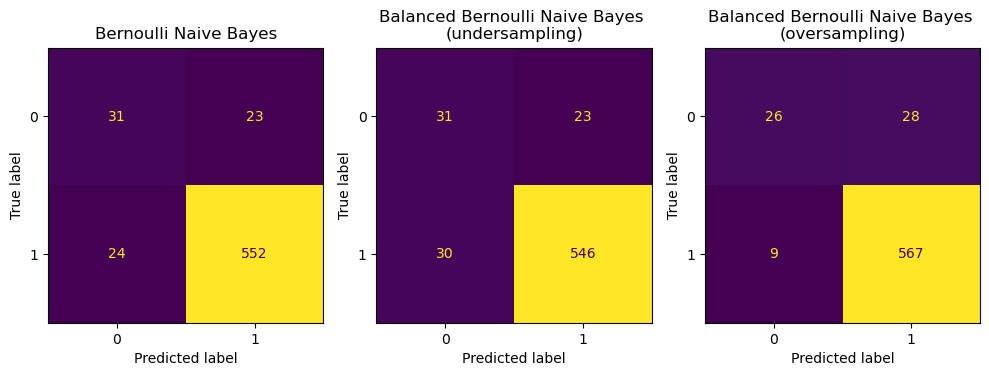

In [200]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(nb_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Bernoulli Naive Bayes")

plot_confusion_matrix(nb_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Bernoulli Naive Bayes \n(undersampling)")

plot_confusion_matrix(nb_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Bernoulli Naive Bayes \n(oversampling)")

fig.tight_layout()

## Random Forest Classifier

In [644]:
rf = RandomForestClassifier(n_estimators = 400, max_depth = 3, class_weight = 'balanced')

In [645]:
rf_param_grid = {   
    #'n_estimators': [200, 300, 400],
    'max_depth': [2, 3],
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'min_samples_split': [2, 3, 4], 
}

In [646]:
rf_grid_search = grid_search_model(rf, rf_param_grid, cv)

In [647]:
%%timeit -r 1 -n 1
rf_grid_search.fit(X_train, y_train)

1min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [648]:
rf_grid_search.best_params_

{'criterion': 'log_loss', 'min_samples_split': 2}

In [649]:
y_pred_rf_train = rf_grid_search.predict(X_train)

cm_rf_train = confusion_matrix(y_train, y_pred_rf_train)
cm_rf_train

array([[ 138,   65],
       [  83, 2234]])

In [650]:
y_pred_rf_test = rf_grid_search.predict(X_test)

cm_rf_test = confusion_matrix(y_test, y_pred_rf_test)
cm_rf_test

array([[ 30,  24],
       [ 26, 550]])

In [651]:
print('Train set')
print('Random Forest Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_pred_rf_train)))

print('Test set')
print('Random Forest Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_rf_test)))

Train set
Random Forest Classifier roc-auc: 0.8219903859032935
Test set
Random Forest Classifier roc-auc: 0.7552083333333334


In [652]:
print(classification_report_imbalanced(y_train, y_pred_rf_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      0.68      0.96      0.65      0.81      0.64       203
          1       0.97      0.96      0.68      0.97      0.81      0.67      2317

avg / total       0.94      0.94      0.70      0.94      0.81      0.67      2520



In [653]:
print(classification_report_imbalanced(y_test, y_pred_rf_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.56      0.95      0.55      0.73      0.51        54
          1       0.96      0.95      0.56      0.96      0.73      0.55       576

avg / total       0.92      0.92      0.59      0.92      0.73      0.55       630



In [856]:
# Save the model results into lists
model_list.append('Random Forest Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_rf_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_rf_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_rf_test), 3))

## Random Forest Classifier with oversampling

In [654]:
rf_os = RandomForestClassifier(n_estimators = 300, max_depth = 3, random_state = 10)

In [655]:
rf_os_grid_search = grid_search_model(rf_os, rf_param_grid, cv)

In [656]:
%%timeit -r 1 -n 1
rf_os_grid_search.fit(X_train_os, y_train_os)

/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [657]:
rf_os_grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 2}

In [658]:
y_pred_rf_os_train = rf_grid_search.predict(X_train_os)

cm_rf_os_train = confusion_matrix(y_train_os, y_pred_rf_os_train)
cm_rf_os_train

array([[1571,  746],
       [  83, 2234]])

In [659]:
y_pred_rf_os_test = rf_os_grid_search.predict(X_test)

cm_rf_os_test = confusion_matrix(y_test, y_pred_rf_os_test)
cm_rf_os_test

array([[ 37,  17],
       [ 54, 522]])

In [660]:
print('Train set')
print('Random Forest Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_rf_os_train)))

print('Test set')
print('Random Forest Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_rf_os_test)))

Train set
Random Forest Classifier with oversampling roc-auc: 0.8211048769961156
Test set
Random Forest Classifier with oversampling roc-auc: 0.7957175925925926


In [822]:
print(classification_report_imbalanced(y_train_os, y_pred_rf_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.68      0.96      0.79      0.81      0.64      2317
          1       0.75      0.96      0.68      0.84      0.81      0.67      2317

avg / total       0.85      0.82      0.82      0.82      0.81      0.65      4634



In [661]:
print(classification_report_imbalanced(y_test, y_pred_rf_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.41      0.69      0.91      0.51      0.79      0.61        54
          1       0.97      0.91      0.69      0.94      0.79      0.63       576

avg / total       0.92      0.89      0.70      0.90      0.79      0.63       630



In [857]:
# Save the model results into lists
model_list.append('Random Forest Classifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_rf_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_rf_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_rf_os_test), 3))

## Random Forest Classifier with undersampling

In [662]:
rf_us = RandomForestClassifier(n_estimators = 300, max_depth = 3)

In [663]:
rf_us_grid_search = grid_search_model(rf_us, rf_param_grid, cv)

In [664]:
%%timeit -r 1 -n 1
rf_us_grid_search.fit(X_train_us, y_train_us)

28.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [665]:
rf_us_grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 3}

In [666]:
y_pred_rf_us_train = rf_us_grid_search.predict(X_train_us)

cm_rf_us_train = confusion_matrix(y_train_us, y_pred_rf_us_train)
cm_rf_us_train

array([[149,  54],
       [  5, 198]])

In [667]:
y_pred_rf_us_test = rf_us_grid_search.predict(X_test)

cm_rf_us_test = confusion_matrix(y_test, y_pred_rf_us_test)
cm_rf_us_test

array([[ 42,  12],
       [ 76, 500]])

In [668]:
print('Train set')
print('Random Forest Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_rf_us_train)))

print('Test set')
print('Random Forest Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_rf_us_test)))

Train set
Random Forest Classifier with undersampling roc-auc: 0.854679802955665
Test set
Random Forest Classifier with undersampling roc-auc: 0.8229166666666667


In [821]:
print(classification_report_imbalanced(y_train_us, y_pred_rf_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.73      0.98      0.83      0.85      0.70       203
          1       0.79      0.98      0.73      0.87      0.85      0.73       203

avg / total       0.88      0.85      0.85      0.85      0.85      0.72       406



In [669]:
print(classification_report_imbalanced(y_test, y_pred_rf_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.36      0.78      0.87      0.49      0.82      0.67        54
          1       0.98      0.87      0.78      0.92      0.82      0.68       576

avg / total       0.92      0.86      0.79      0.88      0.82      0.68       630



In [858]:
# Save the model results into lists
model_list.append('Random Forest Classifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_rf_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_rf_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_rf_us_test), 3))

## Confusion matrix: Random Forest Classifier

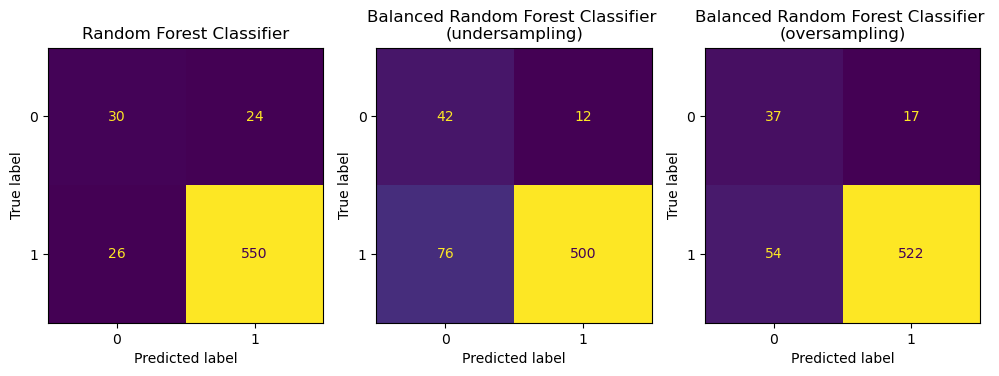

In [670]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(rf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Random Forest Classifier")

plot_confusion_matrix(rf_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Random Forest Classifier \n(undersampling)")

plot_confusion_matrix(rf_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Random Forest Classifier \n(oversampling)")

fig.tight_layout()

## DecisionTreeClassifier

In [264]:
dtree = DecisionTreeClassifier(random_state = 10, max_depth = 6, 
                               class_weight = 'balanced', splitter = 'random')

In [265]:
dtree_param_grid = [
{    'max_depth': [4, 5, 6],
     'criterion': ["gini", "entropy", "log_loss"], 
#      'min_samples_split': [2, 3], 
#      'min_samples_leaf': [1, 2, 3, 4, 5], 
#      'max_features': ["sqrt", "log2"]
}]

In [266]:
dtree_grid_search = grid_search_model(dtree, dtree_param_grid, cv)

In [267]:
%%timeit -r 1 -n 1
dtree_grid_search.fit(X_train, y_train)

26.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [268]:
dtree_grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [269]:
y_pred_dtree_train = dtree_grid_search.predict(X_train)

cm_dtree_train = confusion_matrix(y_train, y_pred_dtree_train)
cm_dtree_train

array([[ 202,    1],
       [1235, 1082]])

In [270]:
y_pred_dtree_test = dtree_grid_search.predict(X_test)

cm_dtree_test = confusion_matrix(y_test, y_pred_dtree_test)
cm_dtree_test

array([[ 53,   1],
       [301, 275]])

In [271]:
print('Train set')
print('Decision Tree Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_pred_dtree_train)))

print('Test set')
print('Decision Tree Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_dtree_test)))

Train set
Decision Tree Classifier roc-auc: 0.731028529757564
Test set
Decision Tree Classifier roc-auc: 0.7294560185185186


In [272]:
print(classification_report_imbalanced(y_train, y_pred_dtree_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.14      1.00      0.47      0.25      0.68      0.49       203
          1       1.00      0.47      1.00      0.64      0.68      0.44      2317

avg / total       0.93      0.51      0.95      0.61      0.68      0.44      2520



In [273]:
print(classification_report_imbalanced(y_test, y_pred_dtree_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.15      0.98      0.48      0.26      0.68      0.49        54
          1       1.00      0.48      0.98      0.65      0.68      0.44       576

avg / total       0.92      0.52      0.94      0.61      0.68      0.45       630



In [859]:
# Save the model results into lists
model_list.append('Decision Tree Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_dtree_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_dtree_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_dtree_test), 3))

## DecisionTreeClassifier with oversampling

In [275]:
dtree_os = DecisionTreeClassifier(random_state = 10, max_depth = 4)

In [276]:
dtree_os_grid_search = grid_search_model(dtree_os, dtree_param_grid, cv)

In [277]:
%%timeit -r 1 -n 1
dtree_os_grid_search.fit(X_train_os, y_train_os)

45.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [279]:
dtree_os_grid_search.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [280]:
y_pred_dtree_os_train = dtree_os_grid_search.predict(X_train_os)

cm_dtree_os_train = confusion_matrix(y_train_os, y_pred_dtree_os_train)
cm_dtree_os_train

array([[2317,    0],
       [1147, 1170]])

In [281]:
y_pred_dtree_os_test = dtree_os_grid_search.predict(X_test)

cm_dtree_os_test = confusion_matrix(y_test, y_pred_dtree_os_test)
cm_dtree_os_test

array([[ 53,   1],
       [292, 284]])

In [282]:
print('Train set')
print('Decision Tree Classifier oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_dtree_os_train)))

print('Test set')
print('Decision Tree Classifier oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_dtree_os_test)))

Train set
Decision Tree Classifier oversampling roc-auc: 0.7524816573154942
Test set
Decision Tree Classifier oversampling roc-auc: 0.7372685185185186


In [823]:
print(classification_report_imbalanced(y_train_os, y_pred_dtree_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.67      1.00      0.50      0.80      0.71      0.53      2317
          1       1.00      0.50      1.00      0.67      0.71      0.48      2317

avg / total       0.83      0.75      0.75      0.74      0.71      0.50      4634



In [283]:
print(classification_report_imbalanced(y_test, y_pred_dtree_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.15      0.98      0.49      0.27      0.70      0.51        54
          1       1.00      0.49      0.98      0.66      0.70      0.46       576

avg / total       0.92      0.53      0.94      0.63      0.70      0.46       630



In [860]:
# Save the model results into lists
model_list.append('Decision Tree Classifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_dtree_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_dtree_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_dtree_os_test), 3))

## DecisionTreeClassifier with undersampling

In [285]:
dtree_us = DecisionTreeClassifier(random_state = 10, max_depth = 5)

In [286]:
dtree_us_grid_search = grid_search_model(dtree_us, dtree_param_grid, cv)

In [287]:
%%timeit -r 1 -n 1
dtree_us_grid_search.fit(X_train_us, y_train_us)

9.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [288]:
dtree_us_grid_search.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [289]:
y_pred_dtree_us_train = dtree_us_grid_search.predict(X_train_us)

cm_dtree_us_train = confusion_matrix(y_train_us, y_pred_dtree_us_train)
cm_dtree_us_train

array([[202,   1],
       [ 95, 108]])

In [290]:
y_pred_dtree_us_test = dtree_us_grid_search.predict(X_test)

cm_dtree_us_test = confusion_matrix(y_test, y_pred_dtree_us_test)
cm_dtree_us_test

array([[ 49,   5],
       [275, 301]])

In [291]:
print('Train set')
print('Decision Tree Classifier undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_dtree_us_train)))

print('Test set')
print('Decision Tree Classifier undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_dtree_us_test)))

Train set
Decision Tree Classifier undersampling roc-auc: 0.7635467980295566
Test set
Decision Tree Classifier undersampling roc-auc: 0.7149884259259259


In [824]:
print(classification_report_imbalanced(y_train_us, y_pred_dtree_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      1.00      0.53      0.81      0.73      0.55       203
          1       0.99      0.53      1.00      0.69      0.73      0.50       203

avg / total       0.84      0.76      0.76      0.75      0.73      0.53       406



In [292]:
print(classification_report_imbalanced(y_test, y_pred_dtree_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.15      0.91      0.52      0.26      0.69      0.49        54
          1       0.98      0.52      0.91      0.68      0.69      0.46       576

avg / total       0.91      0.56      0.87      0.65      0.69      0.46       630



In [861]:
# Save the model results into lists
model_list.append('Decision Tree Classifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_dtree_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_dtree_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_dtree_us_test), 3))

## Confusion matrix: Decision Tree Classifier


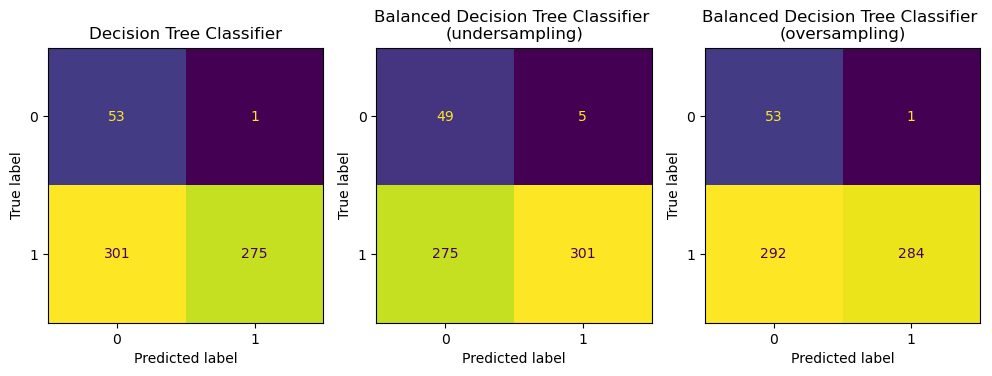

In [294]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(dtree_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Decision Tree Classifier")

plot_confusion_matrix(dtree_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Decision Tree Classifier \n(undersampling)")

plot_confusion_matrix(dtree_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Decision Tree Classifier \n(oversampling)")

fig.tight_layout()

## SVC

In [295]:
svc = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, 
          gamma = 'scale',  C = 0.1, degree = 2)

In [369]:
svc_param_grid = [
{   'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4, 5, 6]
}]

In [297]:
svc_grid_search = grid_search_model(svc, svc_param_grid, cv)

In [298]:
%%timeit -r 1 -n 1
svc_grid_search.fit(X_train, y_train)

18min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [299]:
svc_grid_search.best_params_

{}

In [300]:
y_pred_svc_train = svc_grid_search.predict(X_train)

cm_svc_train = confusion_matrix(y_train, y_pred_svc_train)
cm_svc_train

array([[ 202,    1],
       [ 241, 2076]])

In [301]:
y_pred_svc_test = svc_grid_search.predict(X_test)

cm_svc_test = confusion_matrix(y_test, y_pred_svc_test)
cm_svc_test

array([[ 50,   4],
       [ 87, 489]])

In [302]:
print('Train set')
print('SVC roc-auc: {}'. format(roc_auc_score(y_train, y_pred_svc_train)))

print('Test set')
print('SVC roc-auc: {}'. format(roc_auc_score(y_test, y_pred_svc_test)))

Train set
SVC roc-auc: 0.9455300403315822
Test set
SVC roc-auc: 0.8874421296296298


In [825]:
print(classification_report_imbalanced(y_train, y_pred_svc_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.46      1.00      0.90      0.63      0.94      0.90       203
          1       1.00      0.90      1.00      0.94      0.94      0.88      2317

avg / total       0.96      0.90      0.99      0.92      0.94      0.88      2520



In [303]:
print(classification_report_imbalanced(y_test, y_pred_svc_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.36      0.93      0.85      0.52      0.89      0.79        54
          1       0.99      0.85      0.93      0.91      0.89      0.78       576

avg / total       0.94      0.86      0.92      0.88      0.89      0.78       630



In [862]:
# Save the model results into lists
model_list.append('SVC')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_svc_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_svc_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_svc_test), 3))

## SVC with undersampling

In [353]:
svc_us = SVC(kernel = 'linear', probability = True, gamma = 'scale', C = 0.01, degree = 1)

In [354]:
svc_us_grid_search = grid_search_model(svc_us, svc_param_grid, cv)

In [355]:
%%timeit -r 1 -n 1
svc_us_grid_search.fit(X_train_us, y_train_us)

43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [356]:
svc_us_grid_search.best_params_

{'kernel': 'rbf'}

In [357]:
y_pred_svc_us_train = svc_us_grid_search.predict(X_train_us)

cm_svc_us_train = confusion_matrix(y_train_us, y_pred_svc_us_train)
cm_svc_us_train

array([[203,   0],
       [172,  31]])

In [358]:
y_pred_svc_us_test = svc_us_grid_search.predict(X_test)

cm_svc_us_test = confusion_matrix(y_test, y_pred_svc_us_test)
cm_svc_us_test

array([[ 54,   0],
       [528,  48]])

In [359]:
print('Train set')
print('SVC undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_pred_svc_us_train)))

print('Test set')
print('SVC undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_svc_us_test)))

Train set
SVC undersampling roc-auc: 0.5763546798029556
Test set
SVC undersampling roc-auc: 0.5416666666666666


In [826]:
print(classification_report_imbalanced(y_train_us, y_pred_svc_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      1.00      0.15      0.70      0.39      0.17       203
          1       1.00      0.15      1.00      0.26      0.39      0.14       203

avg / total       0.77      0.58      0.58      0.48      0.39      0.15       406



In [360]:
print(classification_report_imbalanced(y_test, y_pred_svc_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.09      1.00      0.08      0.17      0.29      0.09        54
          1       1.00      0.08      1.00      0.15      0.29      0.08       576

avg / total       0.92      0.16      0.92      0.16      0.29      0.08       630



In [863]:
# Save the model results into lists
model_list.append('SVC (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_svc_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_svc_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_svc_us_test), 3))

## SVC with oversampling

In [370]:
svc_os = SVC(kernel = 'linear', probability = True, gamma = 'scale', C = 0.1, degree = 1)

In [371]:
svc_os_grid_search = grid_search_model(svc_os, svc_param_grid, cv)

In [372]:
%%timeit -r 1 -n 1
svc_os_grid_search.fit(X_train_os, y_train_os)

/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


37min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [373]:
svc_os_grid_search.best_params_

{}

In [374]:
y_pred_svc_os_train = svc_os_grid_search.predict(X_train_os)

cm_svc_os_train = confusion_matrix(y_train_os, y_pred_svc_os_train)
cm_svc_os_train

array([[2303,   14],
       [ 226, 2091]])

In [375]:
y_pred_svc_os_test = svc_os_grid_search.predict(X_test)

cm_svc_os_test = confusion_matrix(y_test, y_pred_svc_os_test)
cm_svc_os_test

array([[ 48,   6],
       [ 74, 502]])

In [376]:
print('Train set')
print('SVC oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_svc_os_train)))

print('Test set')
print('SVC oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_pred_svc_os_test)))

Train set
SVC oversampling roc-auc: 0.9482088908070782
Test set
SVC oversampling roc-auc: 0.8802083333333333


In [828]:
print(classification_report_imbalanced(y_train_os, y_pred_svc_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.99      0.90      0.95      0.95      0.91      2317
          1       0.99      0.90      0.99      0.95      0.95      0.89      2317

avg / total       0.95      0.95      0.95      0.95      0.95      0.90      4634



In [377]:
print(classification_report_imbalanced(y_test, y_pred_svc_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.39      0.89      0.87      0.55      0.88      0.78        54
          1       0.99      0.87      0.89      0.93      0.88      0.77       576

avg / total       0.94      0.87      0.89      0.89      0.88      0.77       630



In [864]:
# Save the model results into lists
model_list.append('SVC (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_svc_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_svc_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_svc_os_test), 3))

## Confusion matrix: SVC

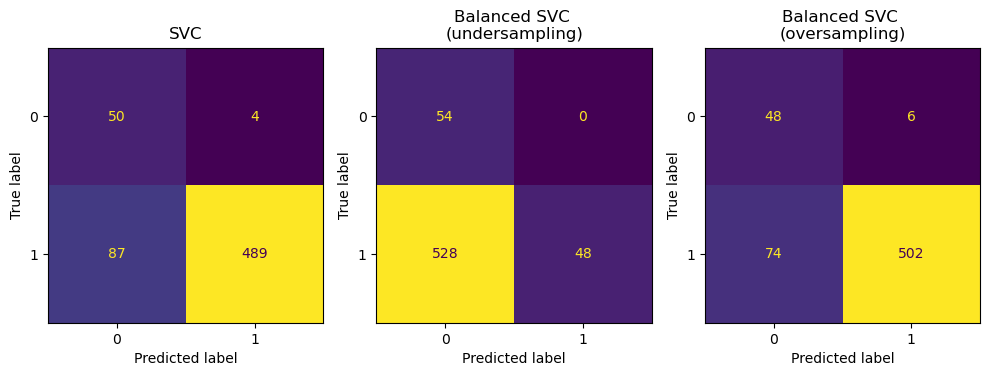

In [379]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(svc_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("SVC")

plot_confusion_matrix(svc_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced SVC \n(undersampling)")

plot_confusion_matrix(svc_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced SVC \n(oversampling)")

fig.tight_layout()

## SGDClassifier

In [380]:
sgd_clf = SGDClassifier(random_state = 0, class_weight = 'balanced', alpha = 0.01, 
                        early_stopping = True, learning_rate = 'optimal', 
                        loss = 'modified_huber', penalty = 'l2')

In [402]:
sgd_clf_param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'], 
    'penalty': ['l2', 'l1'], 
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 
    'alpha': [0.01, 0.1]
}

In [403]:
sgd_clf_grid_search = grid_search_model(sgd_clf, sgd_clf_param_grid, cv)

In [404]:
%%timeit -r 1 -n 1
sgd_clf_grid_search.fit(X_train ,y_train)

/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packa

1min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [415]:
sgd_clf_grid_search.best_params_

{'alpha': 0.01,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'penalty': 'l2'}

In [416]:
y_pred_sgd_train = sgd_clf_grid_search.predict(X_train)

cm_sgd_train = confusion_matrix(y_train, y_pred_sgd_train)
cm_sgd_train

array([[ 176,   27],
       [ 113, 2204]])

In [417]:
y_pred_sgd_test = sgd_clf_grid_search.predict(X_test)

cm_sgd_test = confusion_matrix(y_test, y_pred_sgd_test)
cm_sgd_test

array([[ 40,  14],
       [ 34, 542]])

In [418]:
print('Train set')
print('SGDClassifier roc-auc: {:.3f}'. format(roc_auc_score(y_train, y_pred_sgd_train)))

print('Test set')
print('SGDClassifier roc-auc: {:.3f}'. format(roc_auc_score(y_test, y_pred_sgd_test)))

Train set
SGDClassifier roc-auc: 0.9091125563674789
Test set
SGDClassifier roc-auc: 0.8408564814814814


In [829]:
print(classification_report_imbalanced(y_train, y_pred_sgd_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.87      0.95      0.72      0.91      0.82       203
          1       0.99      0.95      0.87      0.97      0.91      0.83      2317

avg / total       0.96      0.94      0.87      0.95      0.91      0.83      2520



In [419]:
print(classification_report_imbalanced(y_test, y_pred_sgd_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.74      0.94      0.62      0.83      0.68        54
          1       0.97      0.94      0.74      0.96      0.83      0.71       576

avg / total       0.94      0.92      0.76      0.93      0.83      0.71       630



In [865]:
# Save the model results into lists
model_list.append('SGDClassifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_sgd_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_sgd_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_sgd_test), 3))

## SGDClassifier with oversampling

In [420]:
sgd_os = SGDClassifier(random_state = 0, alpha = 0.1)

In [421]:
sgd_os_grid_search = grid_search_model(sgd_os, sgd_clf_param_grid, cv)

In [422]:
%%timeit -r 1 -n 1
sgd_os_grid_search.fit(X_train_os ,y_train_os)

/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

11min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [423]:
sgd_os_grid_search.best_params_

{'alpha': 0.1,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'penalty': 'l2'}

In [424]:
y_pred_sgd_os_train = sgd_os_grid_search.predict(X_train_os)

cm_sgd_os_train = confusion_matrix(y_train_os, y_pred_sgd_os_train)
cm_sgd_os_train

array([[2303,   14],
       [  51, 2266]])

In [425]:
y_pred_sgd_os_test = sgd_os_grid_search.predict(X_test)

cm_sgd_os_test = confusion_matrix(y_test, y_pred_sgd_os_test)
cm_sgd_os_test

array([[ 35,  19],
       [ 38, 538]])

In [426]:
print('Train set')
print('SGDClassifier roc-auc: {}'. format(roc_auc_score(y_train_os, y_pred_sgd_os_train)))

print('Test set')
print('SGDClassifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_sgd_os_test)))

Train set
SGDClassifier roc-auc: 0.9859732412602503
Test set
SGDClassifier roc-auc: 0.7910879629629629


In [831]:
print(classification_report_imbalanced(y_train_os, y_pred_sgd_os_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.99      0.98      0.99      0.99      0.97      2317
          1       0.99      0.98      0.99      0.99      0.99      0.97      2317

avg / total       0.99      0.99      0.99      0.99      0.99      0.97      4634



In [427]:
print(classification_report_imbalanced(y_test, y_pred_sgd_os_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.65      0.93      0.55      0.78      0.59        54
          1       0.97      0.93      0.65      0.95      0.78      0.62       576

avg / total       0.92      0.91      0.67      0.92      0.78      0.62       630



In [866]:
# Save the model results into lists
model_list.append('SGDClassifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_sgd_os_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_sgd_os_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_sgd_os_test), 3))

## SGDClassifier with undersampling

In [429]:
sgd_us = SGDClassifier(random_state = 0, alpha = 1, early_stopping = True)

In [430]:
sgd_us_grid_search = grid_search_model(sgd_us, sgd_clf_param_grid, cv)

In [431]:
%%timeit -r 1 -n 1
sgd_us_grid_search.fit(X_train_us ,y_train_us)

16.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "/Users/OlgaKim/opt/anaconda3/envs/KV-AI-JL-2/lib/python3.9/site-packa

In [432]:
sgd_us_grid_search.best_params_

{'alpha': 0.01,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'penalty': 'l2'}

In [433]:
y_pred_sgd_us_train = sgd_us_grid_search.predict(X_train_us)

cm_sgd_us_train = confusion_matrix(y_train_us, y_pred_sgd_us_train)
cm_sgd_us_train

array([[201,   2],
       [ 28, 175]])

In [434]:
y_pred_sgd_us_test = sgd_us_grid_search.predict(X_test)

cm_sgd_us_test = confusion_matrix(y_test, y_pred_sgd_us_test)
cm_sgd_us_test

array([[ 53,   1],
       [251, 325]])

In [832]:
print(classification_report_imbalanced(y_train_us, y_pred_sgd_us_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.99      0.86      0.93      0.92      0.86       203
          1       0.99      0.86      0.99      0.92      0.92      0.84       203

avg / total       0.93      0.93      0.93      0.93      0.92      0.85       406



In [435]:
print(classification_report_imbalanced(y_test, y_pred_sgd_us_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.17      0.98      0.56      0.30      0.74      0.58        54
          1       1.00      0.56      0.98      0.72      0.74      0.53       576

avg / total       0.93      0.60      0.95      0.68      0.74      0.53       630



In [867]:
# Save the model results into lists
model_list.append('SGDClassifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_sgd_us_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_sgd_us_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_sgd_us_test), 3))

## Confusion matrix: SGDClassifier

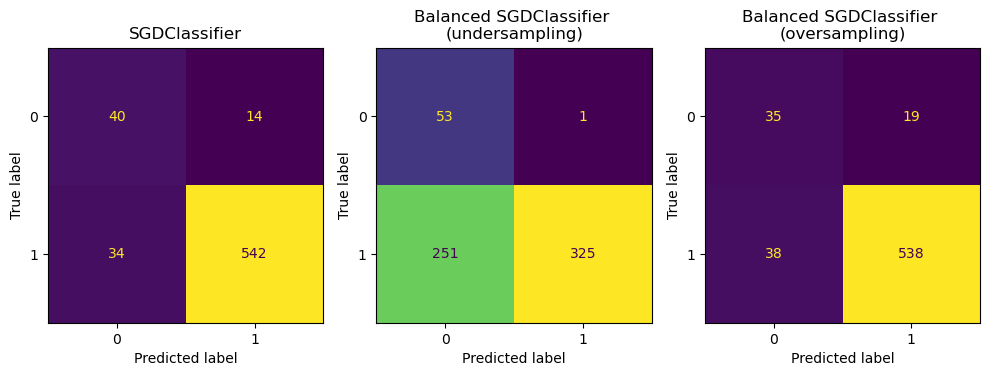

In [437]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(sgd_clf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("SGDClassifier")

plot_confusion_matrix(sgd_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced SGDClassifier \n(undersampling)")

plot_confusion_matrix(sgd_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced SGDClassifier \n(oversampling)")

fig.tight_layout()

# Specific balanced algorithms from imbalanced-learn
## BalancedBaggingClassifier

In [591]:
bbag_clf = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(
                                    max_depth = 11, 
                                    criterion = 'entropy', max_features = 'sqrt',
                                    random_state = 10), 
                                    random_state = 0, n_estimators = 50)

In [592]:
# Parameters for GridSearch CV
bbag_clf_param_grid = {
     'n_estimators': [30, 40, 50], 
}

In [593]:
# GridSearch for BalancedBaggingClassifier
bbag_clf_grid_search = grid_search_model(bbag_clf, bbag_clf_param_grid , cv)

In [594]:
%%timeit -r 1 -n 1     # Calculate the execution time of code 

# Fit the GridSearch for Balanced Bagging Classifier according to the given training data
bbag_clf_grid_search.fit(X_train, y_train)

1min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [595]:
# Best parameters from Grid Search CV for Balanced Bagging Classifier
bbag_clf_grid_search.best_params_

{}

In [596]:
# Prediction for train set
y_pred_bbag_train = bbag_clf_grid_search.predict(X_train)

# Confusion matrix for train set
cm_bbag_train = confusion_matrix(y_train, y_pred_bbag_train)
cm_bbag_train

array([[ 159,   44],
       [ 212, 2105]])

In [597]:
# Prediction for test set
y_pred_bbag_test = bbag_clf_grid_search.predict(X_test)

# Confusion matrix for test set
cm_bbag_test = confusion_matrix(y_test, y_pred_bbag_test)
cm_bbag_test

array([[ 40,  14],
       [ 53, 523]])

In [598]:
print('Train set')
print('Balanced Bagging Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_train, y_pred_bbag_train)))

print('Test set')
print('Balanced Bagging Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_test, y_pred_bbag_test)))

Train set
Balanced Bagging Classifier roc-auc: 0.8458768026431325
Test set
Balanced Bagging Classifier roc-auc: 0.8243634259259259


In [833]:
print(classification_report_imbalanced(y_train, y_pred_bbag_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.43      0.78      0.91      0.55      0.84      0.70       203
          1       0.98      0.91      0.78      0.94      0.84      0.72      2317

avg / total       0.94      0.90      0.79      0.91      0.84      0.72      2520



In [599]:
print(classification_report_imbalanced(y_test, y_pred_bbag_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.43      0.74      0.91      0.54      0.82      0.66        54
          1       0.97      0.91      0.74      0.94      0.82      0.68       576

avg / total       0.93      0.89      0.76      0.91      0.82      0.68       630



In [868]:
# Save the model results into lists
model_list.append('Balanced Bagging Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_bbag_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_bbag_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_bbag_test), 3))

## BalancedRandomForestClassifier

In [700]:
brf_clf = BalancedRandomForestClassifier(random_state = 10, 
                                         criterion = 'entropy', 
                                         max_depth = 12, 
                                         n_estimators = 500)

In [737]:
# Parameters for GridSearch CV
rf_param_grid = {   
    'n_estimators': [500],
    'max_depth': [12],
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'min_samples_split': [2, 3, 4], 
}

In [738]:
# GridSearch for Balanced Random Forest Classifier
brf_clf_grid_search = grid_search_model(brf_clf, rf_param_grid, cv)

In [739]:
%%timeit -r 1 -n 1      # Calculate the execution time of code 

# Fit the GridSearch for Balanced Random Forest Classifier according to the given training data
brf_clf_grid_search.fit(X_train, y_train)

12min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [740]:
# Best parameters from Grid Search CV for Balanced Random Forest Classifier
brf_clf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_split': 2,
 'n_estimators': 500}

In [741]:
# Prediction for train set
y_pred_brf_train = brf_clf_grid_search.predict(X_train)

# Confusion matrix for train set
cm_brf_train = confusion_matrix(y_train, y_pred_brf_train)
cm_brf_train

array([[ 174,   29],
       [ 347, 1970]])

In [742]:
# Prediction for test set
y_pred_brf_test = brf_clf_grid_search.predict(X_test)

# Confusion matrix for test set
cm_brf_test = confusion_matrix(y_test, y_pred_brf_test)
cm_brf_test

array([[ 44,  10],
       [ 80, 496]])

In [743]:
print('Train set')
print('Balanced Random Forest Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_train, y_pred_brf_train)))

print('Test set')
print('Balanced Random Forest Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_test, y_pred_brf_test)))

Train set
Balanced Random Forest Classifier roc-auc: 0.8536901165299957
Test set
Balanced Random Forest Classifier roc-auc: 0.837962962962963


In [835]:
print(classification_report_imbalanced(y_train, y_pred_brf_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.33      0.86      0.85      0.48      0.85      0.73       203
          1       0.99      0.85      0.86      0.91      0.85      0.73      2317

avg / total       0.93      0.85      0.86      0.88      0.85      0.73      2520



In [744]:
print(classification_report_imbalanced(y_test, y_pred_brf_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.35      0.81      0.86      0.49      0.84      0.70        54
          1       0.98      0.86      0.81      0.92      0.84      0.70       576

avg / total       0.93      0.86      0.82      0.88      0.84      0.70       630



In [869]:
# Save the model results into lists
model_list.append('Balanced Random Forest Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_brf_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_brf_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_brf_test), 3))

## EasyEnsembleClassifier

In [541]:
base_estimator = AdaBoostClassifier(random_state = 0, n_estimators = 10)

In [542]:
eec = EasyEnsembleClassifier(n_estimators = 50, base_estimator = base_estimator)

In [543]:
# Parameters for GridSearch CV
eec_param_grid = {
     'n_estimators': [20, 30, 40], 
}

In [544]:
# GridSearch for Easy Ensemble Classifier
eec_grid_search = grid_search_model(eec, eec_param_grid, cv)

In [545]:
%%timeit -r 1 -n 1            # Calculate the execution time of code 

# Fit the GridSearch for Easy Ensemble Classifier according to the given training data
eec_grid_search.fit(X_train, y_train)

2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [546]:
# Best parameters from Grid Search CV for Easy Ensemble Classifier
eec_grid_search.best_params_

{}

In [547]:
# Prediction for train set
y_pred_eec_train = eec_grid_search.predict(X_train)

# Confusion matrix for train set
cm_eec_train = confusion_matrix(y_train, y_pred_eec_train)
cm_eec_train

array([[ 201,    2],
       [ 836, 1481]])

In [548]:
# Prediction for test set
y_pred_eec_test = eec_grid_search.predict(X_test)

# Confusion matrix for test set
cm_eec_test = confusion_matrix(y_test, y_pred_eec_test)
cm_eec_test

array([[ 51,   3],
       [221, 355]])

In [549]:
print('Train set')
print('Easy Ensemble Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_train, y_pred_eec_train)))

print('Test set')
print('Easy Ensemble Classifier roc-auc: {:.3f}'. format(roc_auc_score(y_test, y_pred_eec_test)))

Train set
Easy Ensemble Classifier roc-auc: 0.8146681946036047
Test set
Easy Ensemble Classifier roc-auc: 0.7803819444444444


In [836]:
print(classification_report_imbalanced(y_train, y_pred_eec_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.19      0.99      0.64      0.32      0.80      0.66       203
          1       1.00      0.64      0.99      0.78      0.80      0.61      2317

avg / total       0.93      0.67      0.96      0.74      0.80      0.61      2520



In [550]:
print(classification_report_imbalanced(y_test, y_pred_eec_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.19      0.94      0.62      0.31      0.76      0.60        54
          1       0.99      0.62      0.94      0.76      0.76      0.56       576

avg / total       0.92      0.64      0.92      0.72      0.76      0.57       630



In [870]:
# Save the model results into lists
model_list.append('Easy Ensemble Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_eec_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_eec_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_eec_test), 3))

## RUSBoostClassifier

In [552]:
rusboost = RUSBoostClassifier(n_estimators = 50, base_estimator = base_estimator, learning_rate = 0.1)

In [553]:
# Parameters for GridSearch CV
rusboost_param_grid = {
     'n_estimators': [20, 30, 40, 50], 
}

In [554]:
rusboost_grid_search = grid_search_model(rusboost, rusboost_param_grid, cv)

In [555]:
%%timeit -r 1 -n 1
rusboost_grid_search.fit(X_train, y_train)

3min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [556]:
rusboost_grid_search.best_params_

{}

In [557]:
y_pred_rusboost_train = rusboost_grid_search.predict(X_train)

cm_rusboost_train = confusion_matrix(y_train, y_pred_rusboost_train)
cm_rusboost_train

array([[ 203,    0],
       [ 525, 1792]])

In [558]:
y_pred_rusboost_test = rusboost_grid_search.predict(X_test)

cm_rusboost_test = confusion_matrix(y_test, y_pred_rusboost_test)
cm_rusboost_test

array([[ 49,   5],
       [149, 427]])

In [559]:
print('Train set')
print('RUSBoostClassifier roc-auc: {}'. format(roc_auc_score(y_train, y_pred_rusboost_train)))

print('Test set')
print('RUSBoostClassifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_rusboost_test)))

Train set
RUSBoostClassifier roc-auc: 0.8867069486404834
Test set
RUSBoostClassifier roc-auc: 0.8243634259259259


In [837]:
print(classification_report_imbalanced(y_train, y_pred_rusboost_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      1.00      0.77      0.44      0.88      0.79       203
          1       1.00      0.77      1.00      0.87      0.88      0.76      2317

avg / total       0.94      0.79      0.98      0.84      0.88      0.76      2520



In [560]:
print(classification_report_imbalanced(y_test, y_pred_rusboost_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.91      0.74      0.39      0.82      0.68        54
          1       0.99      0.74      0.91      0.85      0.82      0.66       576

avg / total       0.92      0.76      0.89      0.81      0.82      0.66       630



In [871]:
# Save the model results into lists
model_list.append('RUSBoostClassifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_rusboost_test), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_rusboost_test), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_rusboost_test), 3))

## Confusion matrix: classification from imbalanced-learn 

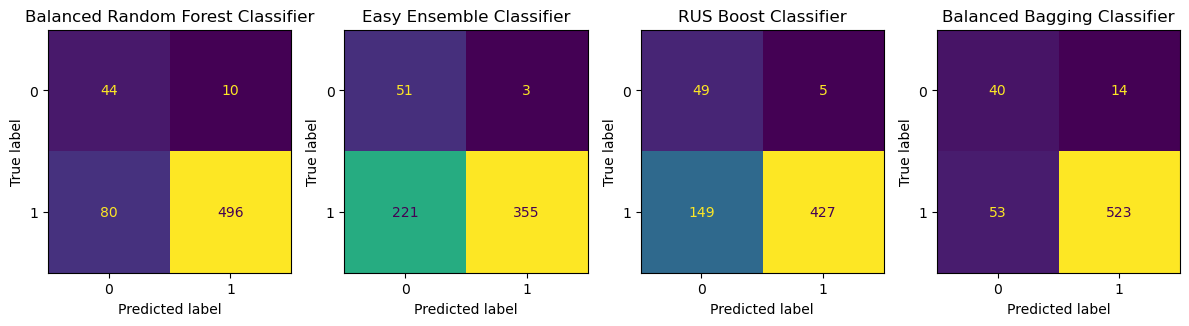

In [796]:
fig, axs = plt.subplots(ncols = 4, figsize = (12, 5))
plot_confusion_matrix(brf_clf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Balanced Random Forest Classifier")

plot_confusion_matrix(eec_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Easy Ensemble Classifier")

plot_confusion_matrix(rusboost_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("RUS Boost Classifier")

plot_confusion_matrix(bbag_clf_grid_search, X_test, y_test, ax = axs[3], colorbar = False)
axs[3].set_title("Balanced Bagging Classifier")

fig.tight_layout()

## Voting Classifier

In [838]:
models = list()
models.append(('log_reg', LogisticRegression(random_state = 0, class_weight = 'balanced', 
                                             C = 0.01, multi_class = 'multinomial', max_iter = 200)))

models.append(('svc', SVC(kernel = 'rbf', 
                          class_weight = 'balanced', 
                          probability = True, 
                          gamma = 'scale', 
                          C = 0.1, 
                          degree = 2, 
                          random_state = 10)))
              
models.append(('brf', BalancedRandomForestClassifier(random_state = 10, criterion = 'entropy', 
                                                     max_depth = 12, n_estimators = 500)))

In [839]:
ensemble = VotingClassifier(estimators = models, voting = 'hard')

In [840]:
%%timeit -r 1 -n 1
ensemble.fit(X_train, y_train)

37.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [841]:
y_pred_voting_train = ensemble.predict(X_train)

cm_voting_train = confusion_matrix(y_train, y_pred_voting_train)
cm_voting_train

array([[ 201,    2],
       [ 347, 1970]])

In [842]:
y_pred_voting = ensemble.predict(X_test)

cm_voting_test = confusion_matrix(y_test, y_pred_voting)
cm_voting_test

array([[ 51,   3],
       [ 96, 480]])

In [843]:
print('Train set')
print('VotingClassifier roc-auc: {}'. format(roc_auc_score(y_train, y_pred_voting_train)))

print('Test set')
print('VotingClassifier roc-auc: {}'. format(roc_auc_score(y_test, y_pred_voting)))

Train set
VotingClassifier roc-auc: 0.9201925795841829
Test set
VotingClassifier roc-auc: 0.888888888888889


In [844]:
print(classification_report_imbalanced(y_train, y_pred_voting_train))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.37      0.99      0.85      0.54      0.92      0.85       203
          1       1.00      0.85      0.99      0.92      0.92      0.83      2317

avg / total       0.95      0.86      0.98      0.89      0.92      0.83      2520



In [845]:
print(classification_report_imbalanced(y_test, y_pred_voting))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.35      0.94      0.83      0.51      0.89      0.80        54
          1       0.99      0.83      0.94      0.91      0.89      0.78       576

avg / total       0.94      0.84      0.93      0.87      0.89      0.78       630



In [872]:
# Save the model results into lists
model_list.append('VotingClassifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_pred_voting), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_pred_voting), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_pred_voting), 3))

## Step #5: Evaluating the models

In [873]:
model_results = pd.DataFrame({'Model': model_list, 
                             'roc_auc_score': roc_auc_score_list, 
                             'balanced_accuracy_score': balanced_accuracy_list, 
                             'geometric_mean_score': geometric_mean_list})
model_results

,Model,roc_auc_score,balanced_accuracy_score,geometric_mean_score
0,Logistic Regression,0.856,0.856,0.851
1,Logistic Regression (oversampling),0.865,0.865,0.862
2,Logistic Regression (undersampling),0.815,0.815,0.798
3,Bagging Classifier,0.775,0.775,0.760
4,Bagging Classifier (oversampling),0.766,0.766,0.744
5,Bagging Classifier (undersampling),0.762,0.762,0.745
6,Bernoulli Naive Bayes,0.766,0.766,0.742
7,Bernoulli Naive Bayes (undersampling),0.761,0.761,0.738
8,Bernoulli Naive Bayes (oversampling),0.733,0.733,0.688
9,Random Forest Classifier,0.755,0.755,0.728


In [874]:
model_results.sort_values(by ='roc_auc_score', ascending = False)

,Model,roc_auc_score,balanced_accuracy_score,geometric_mean_score
25,VotingClassifier,0.889,0.889,0.887
15,SVC,0.887,0.887,0.887
17,SVC (oversampling),0.880,0.880,0.880
1,Logistic Regression (oversampling),0.865,0.865,0.862
0,Logistic Regression,0.856,0.856,0.851
18,SGDClassifier,0.841,0.841,0.835
22,Balanced Random Forest Classifier,0.838,0.838,0.838
24,RUSBoostClassifier,0.824,0.824,0.820
21,Balanced Bagging Classifier,0.824,0.824,0.820
11,Random Forest Classifier (undersampling),0.823,0.823,0.822


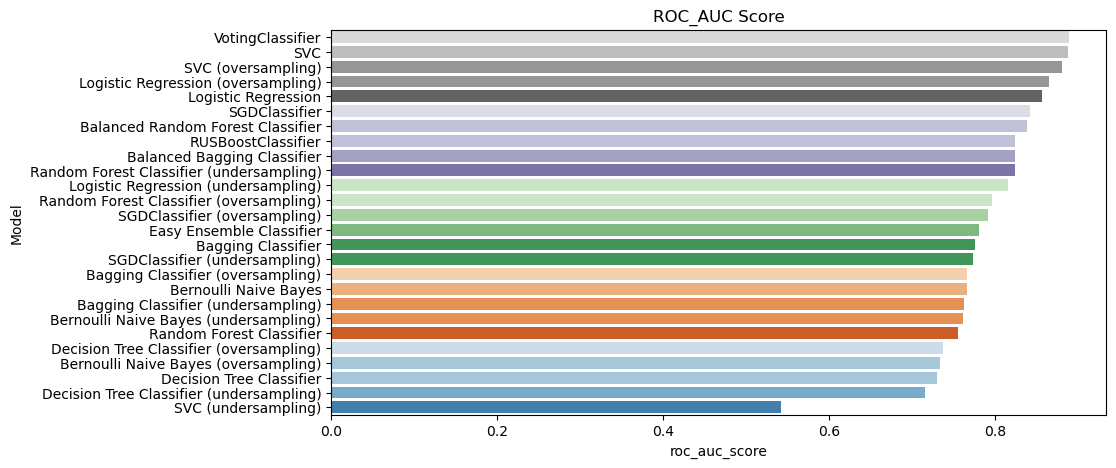

In [875]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='roc_auc_score', ascending = False), 
            x = 'roc_auc_score', y = 'Model', palette = 'tab20c_r')
plt.title("ROC_AUC Score")
plt.show()

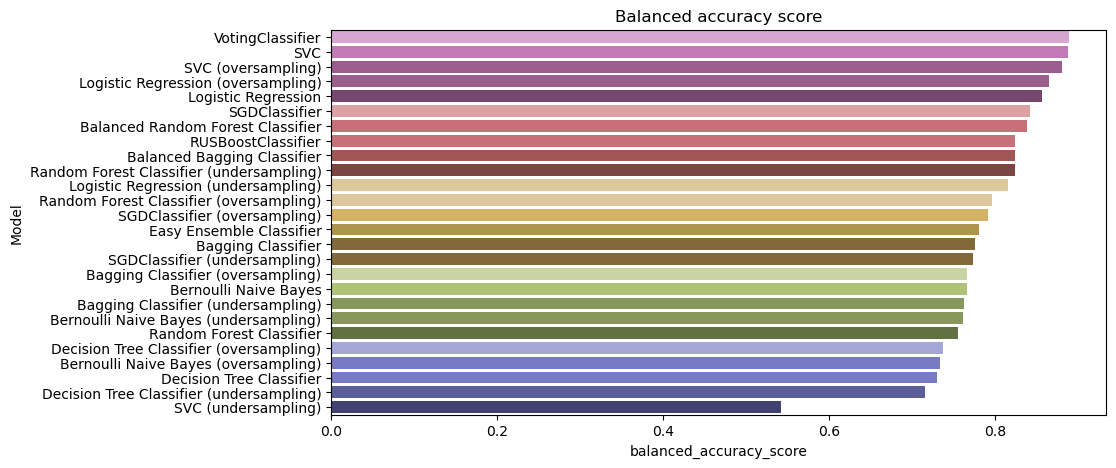

In [876]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='balanced_accuracy_score', ascending = False), 
            x = 'balanced_accuracy_score', y = 'Model', palette = 'tab20b_r')
plt.title("Balanced accuracy score")
plt.show()

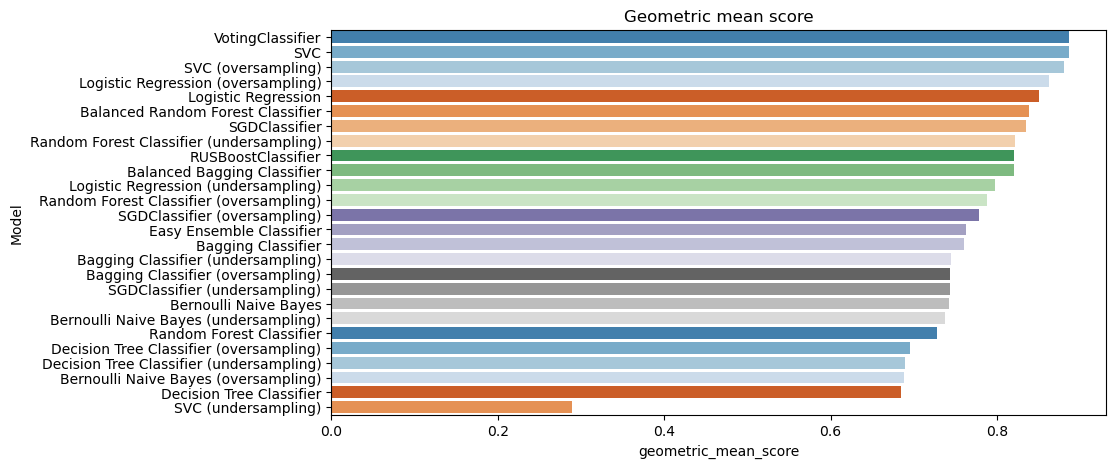

In [877]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='geometric_mean_score', ascending = False), 
            x = 'geometric_mean_score', y = 'Model', palette = 'tab20c')
plt.title("Geometric mean score")
plt.show()

## Step #6: Testing reviews

In [880]:
testing_sample = [str(input("Enter feedback : "))]
testing_sample_vectorizer = vectorizer.transform(testing_sample)
test_review = pd.DataFrame(testing_sample_vectorizer.toarray())
test_predict = ensemble.predict(test_review)
if test_predict == 0:
    print('\nNegative feedback')
else:
    print('\nPositive feedback')

Enter feedback : I have both the Echo Dot and Echo Show and have dealt with Alexa for years. Originally I considered Alexa an expensive, but accurate, timer we used very seldom. Now we it to control lights and television in addition to weather reports and morning alarm. Alexa cannot differentiate voices between users nor can she always understand a southern accent. But while frustrating when the wrong light is turned on or off, it is entertaining when Alexa is asked a question and responds with a totally unexpected answer. And while not Alexa's fault, frustration abounds when the internet connection is lost (either no lights or inability to turn off lights). But still, Alexa has an important position in our family. Note: Alexa advice is not always accurate. For example, it is exactly 2 miles from our house to our work (farm), yet when giving a traffic report (always light) Alexa says we will arrive in 2 minutes not taking into consideration that top speed is 25 MPH (and that ia generou

## Step #7: Conclusion

1. Amazon Alexa review dataset is very unbalanced (2893 positives review vs 257 negative reviews). 

2. Variation of different products of Alexa is not even and have more than 10 varieties (high cardinality).

3. The review length is also different for both positive and negative reviews.

- I've trained models with alexa variation and new created features (like 'length'), but results were all overfitted. And trained with different variations of alexa. And results also were overfitted. So, I used only preprocessed text with TF-IDF vectorizer in training models.

4. In this study I've trained machine learning models with regularization (class_weight = 'balanced'), then implemented balancing methods and specific algorithms from scikit-learn.imbalanced library, and at the end used Voting Classifier.

  *Strategies how to fitting model on imbalanced dataset:

- Penalize with parameter class_weight = 'balanced'
- Balancing the class before classification: from sklearn.imblearn - RandomUnderSampler, RandomOverSampler
- Use of specific balanced algorithms from imbalanced-learn:
    1) BalancedRandomForestClassifier
    2) EasyEnsembleClassifier,
    3) RUSBoostClassifier
    4) BalancedBaggingClassifier
    
5. Insights:
- In the case of an unbalanced dataset, they do a better job of predicting models in which you can adjust parameter class_weight = 'balanced' (like Logistic Regression, some of ensemble models)
- Also, you can apply strategies to balance the dataset, but the result may not always be better than if we did not change the balance

 + Under-sampling can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.
 
 - Under-sampling can discard potentially useful information which could be important for building rule classifiers. The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. Thereby, resulting in inaccurate results with the actual test data set (in my case, SVC).

 + Over-sampling unlike under-sampling, this method leads to no information loss. Outperforms under sampling.
 - But it increases the likelihood of overfitting since it replicates the minority class events.

- And also I used specific models from scikit-learn imbalanced library. They also scored not bad.

6. In accordance with the results of the tested models, the best estimate was shown by VotingClassifier.

## Thank you!